Requirements:

* LabOne Version >= 22.08
* Instruments:
    1 x SHFQC Instrument
<!-- #endregion -->

# Import packages and connect instruments

In [ ]:
%matplotlib notebook
from zhinst.toolkit import Session, SHFQAChannelMode, CommandTable, Waveforms
from zhinst.utils.shfqa import SHFQA_SAMPLING_FREQUENCY

import time
import sys
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams

from scipy.signal import gaussian

import zhinst.utils

device_id = "dev12131"

# apilevel_example = 6 
# (daq, dev, _) = zhinst.utils.create_api_session( 
#     device_id, apilevel_example, server_host="qum.phys.sinica.edu.tw", server_port=8006 
#     ) 

session = Session("192.168.1.15")
device = session.connect_device(device_id)
fs = 2e9 # sampling frequency of QA channel
device_type = device.device_type
print("device_type: %s" %device_type)

# Predefined functions

In [2]:
def seqc_resonator_spec_shfqa(f_start, f_stop, num_points, avg_mode, num_avgs, integration_time):
    integration_length = int(fs*integration_time/4)*4
    if num_points == 1:
        f_step = 0
    else:
        f_step = (f_stop - f_start)/(num_points - 1)
    if avg_mode == 1: # sequential
        n = num_points
        m = num_avgs
        sweep_str = 'setSweepStep(OSC0, i);'
    else:
        n = num_avgs
        m = num_points
        sweep_str = 'setSweepStep(OSC0, j);'
    
    seqc_program = f'''
   
    const OSC0 = 0;
    setTrigger(0);
    configFreqSweep(OSC0, {f_start}, {f_step});
    waitDigTrigger(1);

    for(var i = 0; i < {n}; i++) {{
        for(var j = 0; j < {m}; j++) {{
            // self-triggering mode

            // define time from setting the oscillator frequency to sending
            // the spectroscopy trigger
            playZero(400);

            // set the oscillator frequency depending on the loop variable i
            {sweep_str}
            resetOscPhase();

            // define time to the next iteration
            playZero({integration_length} + 144);

            // trigger the integration unit and pulsed playback in pulsed mode
            setTrigger(1);
            setTrigger(0);

        }}
    }}
    '''
    return seqc_program

def envelope_pulsed_spectroscopy(envelope_duration = 10e-6, envelope_rise_fall_time = 50e-9, do_plot = 0):

    rise_fall_len = int(envelope_rise_fall_time * fs)
    std_dev = rise_fall_len // 10 
    envelope_samples = int(envelope_duration * fs)
    t = np.linspace(0, envelope_duration, envelope_samples)*1e6 # in units of μs
    gauss = gaussian(2 * rise_fall_len, std_dev)

    flat_top_gaussian = np.ones(envelope_samples)*(1-1j)/np.sqrt(2)
    flat_top_gaussian[0:rise_fall_len] = gauss[0:rise_fall_len]*(1-1j)/np.sqrt(2)
    flat_top_gaussian[-rise_fall_len:] = gauss[-rise_fall_len:]*(1-1j)/np.sqrt(2)

    if do_plot == 1:    
        plt.figure()
        plt.plot(t, flat_top_gaussian.real, label = 'real')
        plt.plot(t, flat_top_gaussian.imag, label = 'imag')
        plt.xlabel('Time (μs)')
        plt.ylabel('Amplitude (arb. unit)')
        plt.tight_layout()
        plt.show()
    return flat_top_gaussian * (1 + 0j)

def upload_generate_readout_pulses(device, pulse_duration, rise_fall_time, f_start, phase, num_qubits, scaling):
    
    rise_fall_len = int(rise_fall_time * fs)
    pulse_len = int(pulse_duration * fs)
    std_dev = rise_fall_len // 10
    gauss = gaussian(2 * rise_fall_len, std_dev)
    flat_top_gaussian = np.ones(pulse_len)
    flat_top_gaussian[0:rise_fall_len] = gauss[0:rise_fall_len]
    flat_top_gaussian[-rise_fall_len:] = gauss[-rise_fall_len:]
    flat_top_gaussian *= scaling
    time_vec = np.linspace(0, pulse_duration, pulse_len)

    readout_pulses = Waveforms()
    for i, f in enumerate(f_start):
        readout_pulses.assign_waveform(
            slot=i,
            wave1=flat_top_gaussian * np.exp(2j * np.pi * f * time_vec + 2j * np.pi * phase)
        )
    device.qachannels[0].generator.write_to_waveform_memory(readout_pulses)
    return readout_pulses

def generate_upload_drive_drag_pulses(pulse_duration, pulse_sigma, beta, amp, upload = False, 
                                      device = 'dev12131', channel_index = 0):
    pulse_duration_samples = int(pulse_duration * fs/16)*16
    pulse_sigma_samples = int(pulse_sigma * fs/16)*16
    drive_pulse = Waveforms()
    drive_pulse.assign_waveform(
        slot = 0,
        wave1 = amp * gaussian(pulse_duration_samples, pulse_sigma_samples),
        wave2 = beta * np.concatenate((np.array([0]), np.diff(amp * gaussian(pulse_duration_samples, pulse_sigma_samples))),  axis=None)
        )
    if upload is True:
        device.sgchannels[channel_index].awg.write_to_waveform_memory(drive_pulse)
    return drive_pulse

def seqc_qubit_exp_qa(num_points = 1, num_avgs = 1, delay_after_trigger = 5e-6):
    delay_sample = int(delay_after_trigger * fs/16)*16
    seqc_program = f'''
    repeat({int(num_points*num_avgs)}){{
        waitDigTrigger(1);
        playZero({delay_sample});
        playZero(32);
        startQA(QA_GEN_ALL, QA_INT_ALL, true);
    }}
    '''
    return seqc_program
    
def upload_compile_seqc_sg(start = 0, stop = 0, num_points = 1, num_avgs = 1, avg_mode = 0, dr_pulse_duration = 100e-9,\
            delay_after_trigger = 1e-6, n_cpmg = 1, exp = 'qubit spec', upload_compile = False, device = 'dev12131', channel_index = 0):
    
    step = (stop - start)/(num_points - 1) if num_points is not 1 else 0
    start_sample = int(start * fs / 16) * 16
    stop_sample = int(stop * fs / 16) * 16
    step_sample = int(step * fs / 16) * 16
        
    if avg_mode == 0:
        avg_str = f'''
          for (i = 0; i < {num_avgs}; i = i + 1){{
              for (j = 0; j < {num_points}; j = j + 1){{
              '''
    else:
        avg_str = f'''          
          for (j = 0; j < {num_points}; j = j + 1){{
              for (i = 0; i < {num_avgs}; i = i + 1){{
              '''     
    dr_pulse_sample = int(dr_pulse_duration * fs/16)*16
    delay_sample = int(delay_after_trigger * fs/16)*16
    waveforms_def = f'''assignWaveIndex(1,2,placeholder({dr_pulse_sample}),1,2, placeholder({dr_pulse_sample}), 0);\n'''
    
    seqc_common = f'''
        {waveforms_def}
    '''
    if 'qubit spec' in exp:
        wait_samples = int((delay_sample-dr_pulse_sample)/16)*16
        if exp == 'qubit spec pulsed':
            pulse_str = f'''                  
            playZero({wait_samples});
            executeTableEntry(0);
            '''
        else: 
            assign_waveforms = ''
            pulse_str = ''
            seqc_common = ''
            
        seqc_main = f'''
            const osc = 0;
            const f_start = {start};
            const f_stop = {stop};
            

            configFreqSweep(osc, f_start, {step});
            var i, j;
            {avg_str}
            waitDigTrigger(1);
            resetOscPhase();
            setSweepStep(osc, j);
            {pulse_str}
              }}
            }} 
        '''
    else:
        if avg_mode is 1:
            print('average mode is set to cyclic')
    if 'rabi da' in exp:
        wait_samples = int((delay_after_trigger - dr_pulse_duration) * fs/16)*16
        seqc_main = f'''            
            var i, j;
            for (i = 0; i < {num_avgs}; i++){{
                waitDigTrigger(1);
                resetOscPhase();
                playZero({wait_samples});
                executeTableEntry(0);
                for (j = 0; j < {num_points-1}; j++){{
                    waitDigTrigger(1);
                    resetOscPhase();
                    playZero({wait_samples});
                    executeTableEntry(1);
                }}
            }}'''
    if 't1' in exp:
        wait_samples = int((delay_after_trigger - dr_pulse_duration) * fs/16)*16
        seqc_main = f'''            
            var i, j;
            for (i = 0; i < {num_avgs}; i++){{
                for (j = {start_sample}; j <= {stop_sample}; j = j + {step_sample}){{
                    waitDigTrigger(1);
                    resetOscPhase();
                    playZero({wait_samples}-j);
                    executeTableEntry(1);
                }}
            }}'''
        
    if 'ramsey' in exp:
        wait_samples = int((delay_after_trigger - 2 * dr_pulse_duration) * fs/16)*16
        seqc_main = f'''            
            var i, j;
            for (i = 0; i < {num_avgs}; i++){{
                for (j = {start_sample}; j <={stop_sample}; j = j + {step_sample}){{
                    waitDigTrigger(1);
                    resetOscPhase();
                    playZero({wait_samples}-j);
                    executeTableEntry(0);
                    playZero(j);
                    executeTableEntry(0);
                }}
            }}'''
    if 'hanh echo' in exp:
        wait_samples = int((delay_after_trigger - 3 * dr_pulse_duration) * fs/16)*16
        seqc_main = f'''            
            var i, j;
            for (i = 0; i < {num_avgs}; i++){{
                for (j = {start_sample}; j <= {stop_sample}; j = j + {step_sample}){{
                    waitDigTrigger(1);
                    resetOscPhase();
                    playZero({wait_samples}-2*j);
                    executeTableEntry(1);
                    playZero(j);
                    executeTableEntry(0);
                    playZero(j);
                    executeTableEntry(1);
                }}
            }}''' 
    if 'cpmg' in exp:
        wait_samples = int((delay_after_trigger - (2+n_cpmg) * dr_pulse_duration) * fs/16)*16
        seqc_main = f'''            
            var i, j;
            for (i = 0; i < {num_avgs}; i++){{
                for (j = {start_sample}; j <= {stop_sample}; j = j + {step_sample}){{
                    waitDigTrigger(1);
                    resetOscPhase();
                    playZero({wait_samples}-2*{n_cpmg}*j);
                    executeTableEntry(1);
                    repeat({n_cpmg}){{
                        playZero(j);
                        executeTableEntry(0);
                        playZero(j);
                    }}
                    executeTableEntry(1);
                }}
            }}'''
    if 'weights 2-state' in exp:
        wait_samples = int((delay_after_trigger - dr_pulse_duration) * fs/16)*16
        seqc_main = f'''
        var i, j;
        for (j = 0; j < 4; j = j + 2){{
            for (i = 0; i < {num_avgs}; i++){{
                waitDigTrigger(1);
                resetOscPhase();
                playZero({wait_samples});
                executeTableEntry(2-j);
            }}
        }}
        '''
    if 'thresholds 2-state' in exp:
        wait_samples = int((delay_after_trigger - dr_pulse_duration) * fs/16)*16
        seqc_main = f'''
        var i, j;
        var k = 0;
        for (j = 0; j < {num_points}; j = j + 1){{
            if (j < {int(num_points/2)}){{
                var k = 2;
                }}
            waitDigTrigger(1);
            resetOscPhase();
            playZero({wait_samples});
            executeTableEntry(k);
        }}
        '''
    if 'assignment fidelity 2-state' in exp:
        wait_samples = int((delay_after_trigger - dr_pulse_duration) * fs/16)*16
        seqc_main = f'''
        var i, j;
        for (j = 0; j < {int(num_points/2)}; j = j + 1){{
            for (i = 0; i < {num_avgs}; i = i + 1){{
                waitDigTrigger(1);
                resetOscPhase();
                playZero({wait_samples});
                executeTableEntry(2);
                waitDigTrigger(1);
                resetOscPhase();
                playZero({wait_samples});
                executeTableEntry(0);
            }}
        }}
        '''        
        
    if upload_compile is True:
        elf_file, info = device.sgchannels[channel_index].awg.compile_sequencer_program(seqc_common + seqc_main)
        device.sgchannels[channel_index].awg.elf.data(elf_file)
    return  seqc_common + seqc_main

def upload_ct_sg(start=0, stop=1, num_points=2, exp = 'qubit spec pulsed', upload = True, 
                 device = 'dev12131', channel_index = 0):
    
    step = (stop - start)/(num_points - 1) if num_points is not 1 else 0
    ct = CommandTable(device.sgchannels[channel_index].awg.commandtable.load_validation_schema())
    if 'qubit spec pulsed' or 'ramsey' or 't1' or 'hanh echo' or 'cpmg' or 'weights 2-state' or 'thresholds 2-state' or 'assignment fidelity 2-state' in exp:
        ct.table[0].waveform.index = 0
        ct.table[0].amplitude00.value = 1; ct.table[0].amplitude00.increment = False
        ct.table[0].amplitude01.value = -1; ct.table[0].amplitude01.increment = False
        ct.table[0].amplitude10.value = 1; ct.table[0].amplitude10.increment = False
        ct.table[0].amplitude11.value = 1; ct.table[0].amplitude11.increment = False
        ct.table[1].waveform.index = 0
        ct.table[1].amplitude00.value = 0.5; ct.table[0].amplitude00.increment = False
        ct.table[1].amplitude01.value = -0.5; ct.table[0].amplitude01.increment = False
        ct.table[1].amplitude10.value = 0.5; ct.table[0].amplitude10.increment = False
        ct.table[1].amplitude11.value = 0.5; ct.table[0].amplitude11.increment = False
        ct.table[2].waveform.index = 0
        ct.table[2].amplitude00.value = 0; ct.table[0].amplitude00.increment = False
        ct.table[2].amplitude01.value = -0; ct.table[0].amplitude01.increment = False
        ct.table[2].amplitude10.value = 0; ct.table[0].amplitude10.increment = False
        ct.table[2].amplitude11.value = 0; ct.table[0].amplitude11.increment = False        
        
        
    if 'rabi da' in exp:
        if stop > 1:
            print('amplitude scaling factor > 1 is invalid') 
        ct.table[0].waveform.index = 0
        ct.table[0].amplitude00.value = start; ct.table[0].amplitude00.increment = False
        ct.table[0].amplitude01.value = -start; ct.table[0].amplitude01.increment = False
        ct.table[0].amplitude10.value = start; ct.table[0].amplitude10.increment = False
        ct.table[0].amplitude11.value = start; ct.table[0].amplitude11.increment = False
        ct.table[1].waveform.index = 0
        ct.table[1].amplitude00.value = step; ct.table[1].amplitude00.increment = True
        ct.table[1].amplitude01.value = -step; ct.table[1].amplitude01.increment = True
        ct.table[1].amplitude10.value = step; ct.table[1].amplitude10.increment = True
        ct.table[1].amplitude11.value = step; ct.table[1].amplitude11.increment = True        
    device.sgchannels[channel_index].awg.commandtable.upload_to_device(ct)
    return ct
             
def plot_sweeper(f, result, unwrap = True, deg = True):
    fig, ax = plt.subplots()
    f = f/1e9
    power = 10*np.log10(np.abs(result)**2/50*1000)
    phase = np.unwrap(np.angle(result, deg = deg)) if unwrap is True else np.angle(result, deg = deg)
    phase_unit = 'deg' if deg is True else 'rad'
    ax.plot(f, power, '.-', color = 'steelblue', label = 'power')
    ax.legend(loc='upper left')
    ax.set_ylabel('Power (dBm)')    
    ax1 = ax.twinx()
#     ax1.plot(f, phase, '.-', color = 'orange', label = 'phase')
    ax1.legend(loc='upper right')
    ax.set_xlabel('Frequency (GHz)')
    ax.grid()
    ax1.set_ylabel(f'Phase ({phase_unit})')
    plt.tight_layout()

def plot_2d(x, y, z):
    x0 = np.zeros(len(x)+1)    
    x0[:-1] = x - (x[1]-x[0])/2
    x0[-1]= x[-1] + (x[1]-x[0])/2    
    y0 = np.zeros(len(y)+1)
    y0[:-1] = y - (y[1]-y[0])/2
    y0[-1]= y[-1] + (y[1]-y[0])/2
    
    z_abs = 10*np.log10(np.abs(z)**2/50*1000)
    z_angle = np.angle(z, deg = True)
    X, Y = np.meshgrid(x0 ,y0)
    
    fig, (ax0, ax1) = plt.subplots(nrows = 2, sharex = True)
    c0 = ax0.pcolormesh(X, Y,z_abs)
    ax0.set_yticks(y)
    ax0.set_ylabel('Gain')
    ax0.set_title('Power (dBm)')
    fig.colorbar(c0, ax=ax0)

    c1 = ax1.pcolormesh(X, Y, z_angle)
    ax1.set_yticks(y)
    ax1.set_xlabel('Offset frequency (GHz)')
    ax1.set_ylabel('Gain')
    ax1.set_title('Phase (degree)')
    fig.colorbar(c1, ax=ax1)

    fig.tight_layout()
    
def plot_readout_IQ(data, num_qubits):
    fig, ax = plt.subplots()
    for i in range(num_qubits):
        ax.scatter(data.real[i], data.imag[i], label = f'qubit {i}')
    ax.set_xlabel('Real (Vrms)')
    ax.set_ylabel('Imag (Vrms)')
    ax.grid()
    ax.legend()
    plt.tight_layout()
    
def plot_qubit_readout_amp_phase(integration_length, x, ys, exp = 'qubit spec', unwrap = False, deg = True):
    power = 10*np.log10(np.abs(ys/integration_length)**2/50*1000)
    phase = np.unwrap(np.angle(ys/integration_length, deg = deg)) if unwrap is True else np.angle(ys, deg = deg)
    phase_unit = 'deg' if deg is True else 'rad'   
    
    if 'qubit spec' in exp:
        x = x/1e9
        x_label = 'Frequency (GHz)'
    if 'rabi da' in exp:
        x_label = 'Amplitude scaling factor'
    if 'ramsey' or 't1' or 'hanh echo' or 'cpmg' in exp:
        x = x*1e6
        x_label = r'τ (μs)'
    for i in range(len(ys)):
        fig, ax = plt.subplots()
        ax1 = ax.twinx()
        ax.plot(x, power[i], '.-', color = 'steelblue', label = f'power: qubit {i}')
        ax1.plot(x, phase[i], '.-', color = 'orange', label = f'phase: qubit {i}')
        ax.legend(loc='upper left')
        ax.set_ylabel('Power (dBm)')     
        ax1.legend(loc='upper right')
        ax.set_xlabel(x_label)
        ax1.set_ylabel(f'Phase ({phase_unit})')
        ax.grid()
        plt.tight_layout()
        plt.show()

def plot_2_state_threshold_histogram(readout_results, num_bins, ind_q):
    import scipy as scy
    from scipy.optimize import leastsq
    from scipy.stats import norm
    
    n_shots = int(len(readout_results[ind_q])/2)

    fitfunc  = lambda p, x: p[0]*exp(-0.5*((x-p[1])/p[2])**2)+p[3]
    errfunc  = lambda p, x, y: (y - fitfunc(p, x))

    g_real = np.real(readout_results[ind_q][0:n_shots])
    g_imag = np.imag(readout_results[ind_q][0:n_shots])
    e_real = np.real(readout_results[ind_q][n_shots::])
    e_imag = np.imag(readout_results[ind_q][n_shots::])
    (g_mu, g_sigma) = norm.fit(g_real)
    (e_mu, e_sigma) = norm.fit(e_real)

    fitfunc  = lambda p, x: p[0]*exp(-0.5*((x-p[1])/p[2])**2)+p[3]
    errfunc  = lambda p, x, y: (y - fitfunc(p, x))

    fig, ax = plt.subplots()
    g_n, g_bins, g_patches = ax.hist(g_real, num_bins, density=1, label = 'state 0', color = 'steelblue')
    e_n, e_bins, e_patches = ax.hist(e_real, num_bins, density=1, label = 'state 1', color = 'orange')

    g_init  = [max(g_n), g_mu, g_sigma, min(g_n)]
    e_init  = [max(e_n), e_mu, e_sigma, min(e_n)]
    mu_g, sigma_g = scy.stats.norm.fit(g_real)
    mu_e, sigma_e = scy.stats.norm.fit(e_real)
    threshold = np.mean([mu_g, mu_e])
    best_fit_line_g = scy.stats.norm.pdf(g_bins, mu_g, sigma_g)
    best_fit_line_e = scy.stats.norm.pdf(e_bins, mu_e, sigma_e)
    
    plt.plot(g_bins, best_fit_line_g, '--', color = 'steelblue')
    plt.plot(e_bins, best_fit_line_e, '--', color = 'orange')
    plt.plot(np.ones(10)*threshold, np.linspace(0, 1.1*max(g_n), 10), '--')
    plt.xlabel('Result after integration before normalization (Vrms)')
    plt.ylabel('Counts')
    plt.title(f'Qubit {ind_q} threshold: {threshold}')
    plt.legend()
    plt.show()
    plt.tight_layout()
    return threshold, mu_g, mu_e
    
def plot_uplaoded_waveform(device, ch_ind, readout_ind, weight_ind, num_samples):
    plt.figure()
    readout_wave = device.qachannels[ch_ind].generator.waveforms[readout_ind].wave()
    weight_wave  = device.qachannels[ch_ind].readout.integration.weights[weight_ind].wave()
    plt.plot(np.real(readout_wave[:num_samples]), '.-', label = 'real readout pulse')
    plt.plot(np.real(weight_wave[:num_samples]), '.-', label = 'real integration weight')
    plt.plot(np.imag(readout_wave[:num_samples]), '.-', label = 'imag readout pulse')
    plt.plot(np.imag(weight_wave[:num_samples]), '.-', label = 'imag integration weight')
    plt.xlabel('Sample points')
    plt.ylabel('Amplitude (arb. unit)')
    plt.legend()
    plt.tight_layout()
       
def plot_measured_weights(weights):
    plt.figure()
    t = np.linspace(0, (1-len(weights))/fs, len(weights))*1e6
    plt.plot(t, weights.real, '-o', label = 'real')
    plt.plot(t, weights.imag, '.-', label = 'imag')
    plt.legend()
    plt.xlabel('t (μs)')
    plt.ylabel('Amplitude (Vrms)')
    plt.tight_layout()

def plot_after_thresholding(data, label):
    plt.figure()
    plt.plot(data, '-o', label = label)
    plt.legend()
    plt.xlabel('Sample points')
    plt.ylabel('Discriminated state')
    plt.tight_layout()

def plot_scope_data(scope_data, trigger_delay):
    
    n = 2
    if '4' in device_type:
        n = 4
        
    plt.figure()
    for i in range(n): 
        if len(scope_data[i]) > 0:
            x = np.linspace(trigger_delay, trigger_delay + len(scope_data[i])/fs, len(scope_data[i]))
            plt.plot(x/1e-6, scope_data[i].real, '.-', label = f'real part of scope data {i}')
            plt.plot(x/1e-6, scope_data[i].imag, '.-', label = f'imag part of scope data {i}')
    plt.legend()
    plt.xlabel('Time (μs)')
    plt.ylabel('Amplitude (Vrms)')
    plt.tight_layout()

def voltage_to_power_dBm(voltage):
    power = 10 * np.log10(np.abs(voltage) ** 2 / 50 * 1000)
    return power


def voltage_to_phase(voltage):
    phase = np.unwrap(np.angle(voltage))
    return phase


def generate_flat_top_gaussian(
    frequencies, pulse_duration, rise_fall_time, sampling_rate, scaling=0.9
):
    """Returns complex flat top Gaussian waveforms modulated with the given frequencies.
    Args:
        frequencies (array): array specifying the modulation frequencies applied to each
                             output wave Gaussian
        pulse_duration (float): total duration of each Gaussian in seconds
        rise_fall_time (float): rise-fall time of each Gaussian edge in seconds
        sampling_rate (float): sampling rate in samples per second based on which to
                               generate the waveforms
        scaling (optional float): scaling factor applied to the generated waveforms (<=1);
                                  use a scaling factor <= 0.9 to avoid overshoots
    Returns:
        pulses (dict): dictionary containing the flat top Gaussians as values
    """
    if scaling > 1:
        raise ValueError(
            "The scaling factor has to be <= 1 to ensure the generated waveforms lie within the \
                unit circle."
        )

    from scipy.signal import gaussian

    rise_fall_len = int(rise_fall_time * sampling_rate)
    pulse_len = int(pulse_duration * sampling_rate)

    std_dev = rise_fall_len // 10

    gauss = gaussian(2 * rise_fall_len, std_dev)
    flat_top_gaussian = np.ones(pulse_len)
    flat_top_gaussian[0:rise_fall_len] = gauss[0:rise_fall_len]
    flat_top_gaussian[-rise_fall_len:] = gauss[-rise_fall_len:]

    flat_top_gaussian *= scaling

    pulses = {}
    time_vec = np.linspace(0, pulse_duration, pulse_len)

    for i, f in enumerate(frequencies):
        pulses[i] = flat_top_gaussian * np.exp(2j * np.pi * f * time_vec)

    return pulses


def set_trigger_loopback(session, device, rate=1000):
    """
    Start a continuous trigger pulse from marker 1 A using the internal loopback to trigger in 1 A
    """

    m_ch = 0
    low_trig = 2
    continuous_trig = 1
    daq = session.daq_server
    daq.syncSetInt(f"/{device.serial}/raw/markers/*/testsource", low_trig)
    daq.setInt(f"/{device.serial}/raw/markers/{m_ch}/testsource", continuous_trig)
    daq.setDouble(f"/{device.serial}/raw/markers/{m_ch}/frequency", rate)
    daq.setInt(f"/{device.serial}/raw/triggers/{m_ch}/loopback", 1)
    time.sleep(0.2)


def clear_trigger_loopback(session, device):
    m_ch = 0
    session.daq_server.setInt(f"/{device.serial}/raw/markers/*/testsource", 0)
    session.daq_server.setInt(f"/{device.serial}/raw/triggers/{m_ch}/loopback", 0)


def run_experiment(device, sgchannel_number, number_of_qubits, reenable=False):
    if reenable:
        with device.set_transaction():
            device.qachannels[0].readout.run()
            device.qachannels[0].generator.enable_sequencer(single=True)
            device.qachannels[0].input.on(1)
            device.qachannels[0].output.on(1)
            for qubit in range(number_of_qubits):
                channel = sgchannel_number[qubit]
                device.sgchannels[channel].awg.enable(1)
                device.sgchannels[channel].output.on(1)
    else:
        with device.set_transaction():
            device.qachannels[0].input.on(1)
            device.qachannels[0].output.on(1)
            for qubit in range(number_of_qubits):
                device.sgchannels[sgchannel_number[qubit]].output.on(1)

    device.start_continuous_sw_trigger(num_triggers=1, wait_time=2e-3)

    readout_results = device.qachannels[0].readout.read(timeout=100)

    with device.set_transaction():
        device.qachannels[0].input.on(0)
        device.qachannels[0].output.on(0)
        for qubit in range(number_of_qubits):
            device.sgchannels[sgchannel_number[qubit]].output.on(0)

    return readout_results


def fit_data(
    x_data,
    y_data,
    function,
    start_param,
    do_plot,
    figsize=10,
    font=10,
    qubit=0,
    x_label="",
    y_label="",
    saveloc="",
):

    pars, cov = curve_fit(
        f=function, xdata=x_data, ydata=y_data, p0=start_param, bounds=(-np.inf, np.inf)
    )
    stdevs = np.sqrt(np.diag(cov))
    residuals = y_data - function(x_data, *pars)

    # plot it
    if do_plot:
        fig4, axs = plt.subplots(2, 1, figsize=figsize)
        fig4.suptitle(f"Qubit {qubit}", fontsize=font)
        axs[0].scatter(x_data, y_data, s=20, color="#00b3b3", label="Data")
        axs[0].plot(
            x_data, function(x_data, *pars), linestyle="--", linewidth=2, color="black"
        )
        axs[0].legend(loc=2, prop={"size": font})

        axs[0].set_xlabel(x_label, fontsize=font)
        axs[0].set_ylabel(y_label, fontsize=font)
        axs[0].tick_params(axis="both", which="major", labelsize=font)

        axs[1].plot(x_data, residuals, ".")
        axs[1].set_xlabel(x_label, fontsize=font)
        axs[1].set_ylabel("residuals", fontsize=font)
        axs[1].tick_params(axis="both", which="major", labelsize=font)

        plt.savefig(saveloc)
        plt.show()

    return pars, stdevs


def amplitude_rabi(amp, Omega, amplitude):
    return -amplitude * np.cos(amp * Omega / 2) + amplitude

<>:119: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:170: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:303: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:119: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:170: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:303: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/var/folders/p4/8nj0cv354f54pc39_6581jnc0000gn/T/ipykernel_30566/2809937205.py:119: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  step = (stop - start)/(num_points - 1) if num_points is not 1 else 0
/var/folders/p4/8nj0cv354f54pc39_6581jnc0000gn/T/ipykernel_30566/2809937205.py:170: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if avg_mode is 1:
/var/folders/p4/8nj0cv354f54pc39_6581jnc0000gn/T/ipykernel_30566/2809937205.py:303: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  step = (stop - start)/(num_points - 1) if num_points is not 1 else 0


## Plot parameters

In [3]:
pi=np.pi
SMALL_SIZE = 14
MEDIUM_SIZE = 14
BIGGER_SIZE = 16
rcParams['figure.figsize'] = 8, 4
plt.rc('font', size=SMALL_SIZE, style='normal', weight = 'normal')          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

colors = ['#1f77b4',
          '#ff7f0e',
          '#2ca02c',
          '#d62728',
          '#9467bd',
          '#8c564b',
          '#e377c2',
          '#7f7f7f',
          '#bcbd22',
          '#17becf',]

# Resonator spectroscopy

## Set parameters

In [4]:
ro_cent_f = 6.5e9 # in Hz; output frequency = ro_cent_f + ro_offset_f
ro_out_range = -30 # in dBm
ro_in_range = -50  

# define sweep and integration parameters
ro_start_f = -102.5e6
ro_stop_f  = -97.5e6
ro_osc_gain = 1/1
num_points = 500
num_avgs   = 16000 
integration_time = 2e-6 # maximum 16ms (continuous) and 16us (pulsed)
integration_delay = 324e-9

envelope_duration = 32e-6 if integration_time >32e-6 else integration_time
envelope_rise_fall_time = 0.008e-6
envelope_delay = 0

do_plot = 0
flat_top_gaussian = envelope_pulsed_spectroscopy(envelope_duration, envelope_rise_fall_time, do_plot)


# turn on inputs and outputs 
with device.set_transaction():
    device.qachannels[0].input.on(1)
    device.qachannels[0].output.on(1) 
        
# create a sweeper module and configure the sweeper
sweeper = session.modules.shfqa_sweeper
sweeper.device(device)
sweeper.rf.channel(0)
sweeper.rf.input_range(ro_in_range)
sweeper.rf.output_range(ro_out_range)
sweeper.rf.center_freq(ro_cent_f)
sweeper.sweep.oscillator_gain(ro_osc_gain)
sweeper.sweep.start_freq(ro_start_f)
sweeper.sweep.stop_freq(ro_stop_f)
sweeper.sweep.num_points(num_points)
sweeper.average.num_averages(num_avgs)
# sweeper.average.mode("sequential")
sweeper.average.mode("cyclic")
# The sequencer is used by default but can be disabled manually
# (sequencer-based sweep (True) or the slower host-driven sweep (False))
sweeper.sweep.use_sequencer=True
sweeper.average.integration_time(integration_time)
sweeper.average.integration_delay(integration_delay)
sweeper.envelope.enable(0)
# list(sweeper)
sweeper.sweep.wait_after_integration(0e-6)

## Continuous wave output

Run a sweep with 500 frequency points in the range of [-102.5, -97.5] MHz + 6.5 GHz. 
Mapping is linear. 
Integration time = 2e-06 sec. 
Measures 16000 times per frequency point. 
Averaging mode is cyclic.
Trigger source is set to None, which means the sequencer defines the repetition rate.
Measurement (8000000/8000000) at -102.500MHz.                    
Measured at 500 frequency points.


<IPython.core.display.Javascript object>


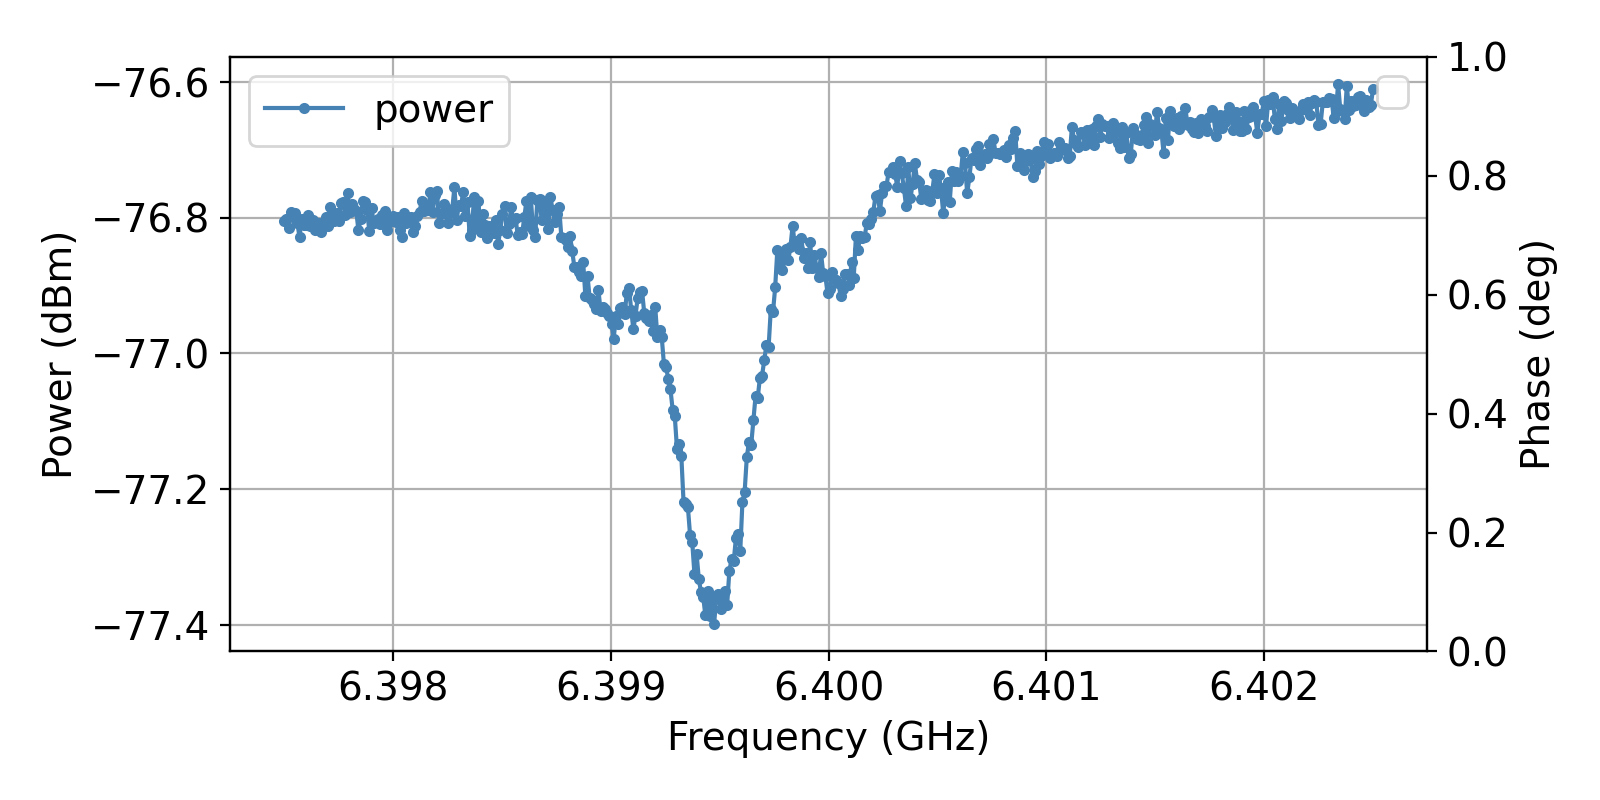

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [5]:
result = sweeper.run()
num_points_result = len(result["vector"])
print(f"Measured at {num_points_result} frequency points.")
plot_sweeper(np.linspace(ro_start_f, ro_stop_f, num_points) + ro_cent_f, result["vector"], unwrap = False, deg = True)
# sweeper.plot()
# plt.tight_layout()
# plt.show()

In [23]:
list(sweeper)

[(/sweep/start_freq,
  {'Node': '/sweep/start_freq',
   'Description': 'Minimum frequency for the sweep',
   'Properties': 'Read, Write',
   'Unit': 'Hz',
   'Type': 'Double'}),
 (/sweep/stop_freq,
  {'Node': '/sweep/stop_freq',
   'Description': 'Maximum frequency for the sweep',
   'Properties': 'Read, Write',
   'Unit': 'Hz',
   'Type': 'Double'}),
 (/sweep/num_points,
  {'Node': '/sweep/num_points',
   'Description': 'Number of frequency points to measure',
   'Properties': 'Read, Write',
   'Unit': 'None',
   'Type': 'Integer'}),
 (/sweep/mapping,
  {'Node': '/sweep/mapping',
   'Description': 'Linear or logarithmic frequency axis',
   'Properties': 'Read, Write',
   'Unit': 'None',
   'Type': 'Integer',
   'Options': {'0': '"linear": Linear frequency axis.',
    '1': '"log": Logarithmic frequency axis.'}}),
 (/sweep/oscillator_gain,
  {'Node': '/sweep/oscillator_gain',
   'Description': 'Amplitude gain for the oscilator used for modulation',
   'Properties': 'Read, Write',
   'Un

## Pulsed output

### Measure total delay between pulse generation and integration

measured integration delay: 1548.0 ns


<IPython.core.display.Javascript object>


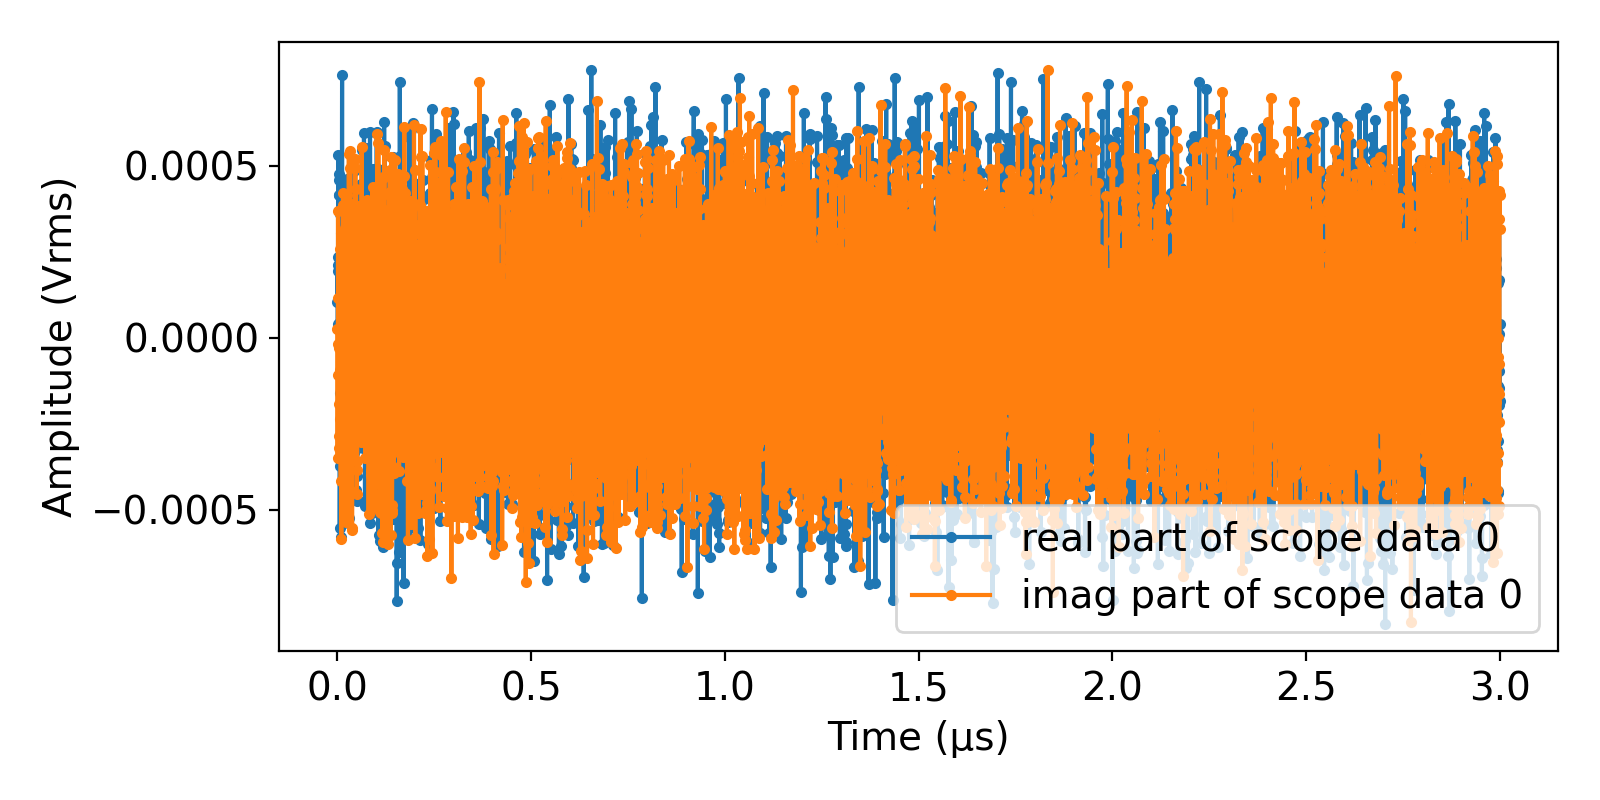

In [60]:
# configure scope 
scope_channel = 0
recording_time = envelope_duration + 1e-6

with device.set_transaction():
    device.qachannels[0].spectroscopy.envelope.enable(1)
    device.qachannels[0].spectroscopy.envelope.wave(flat_top_gaussian)
    
    device.scopes[0].trigger.enable(1)
    device.scopes[0].trigger.channel(32) 
    device.scopes[0].trigger.delay(0)        
    device.scopes[0].length(int(recording_time * fs))
    device.scopes[0].channels[scope_channel].inputselect(0)
    device.scopes[0].channels[scope_channel].enable(1)
    device.scopes[0].averaging.enable(0)
    device.scopes[0].segments.enable(0)
    device.qachannels[0].oscs[0].freq(230.4e6)
    device.qachannels[0].spectroscopy.trigger.channel(32)
    
     
seqc_program = f"""
    repeat(1) {{
        resetOscPhase(); 
        setTrigger(1); setTrigger(0);        
    }}
""" 
device.scopes[0].run(single = True)   
device.qachannels[0].generator.load_sequencer_program(seqc_program)
device.qachannels[0].generator.single(1)
device.qachannels[0].generator.enable(1)
scope_data, *_ = device.scopes[0].read()
integration_delay = int((np.argmin(np.diff(scope_data[0].real))+1)/4)*4/fs
print(f'measured integration delay: {integration_delay*1e9} ns')
plot_scope_data(scope_data, 0)

### Pulsed resonator spectroscopy

Run a sweep with 500 frequency points in the range of [-102.5, -97.5] MHz + 6.5 GHz. 
Mapping is linear. 
Integration time = 2e-06 sec. 
Measures 16000 times per frequency point. 
Averaging mode is cyclic.
Trigger source is set to None, which means the sequencer defines the repetition rate.
Measurement (8000000/8000000) at -102.500MHz.                    
Measured at 500 frequency points.


<IPython.core.display.Javascript object>


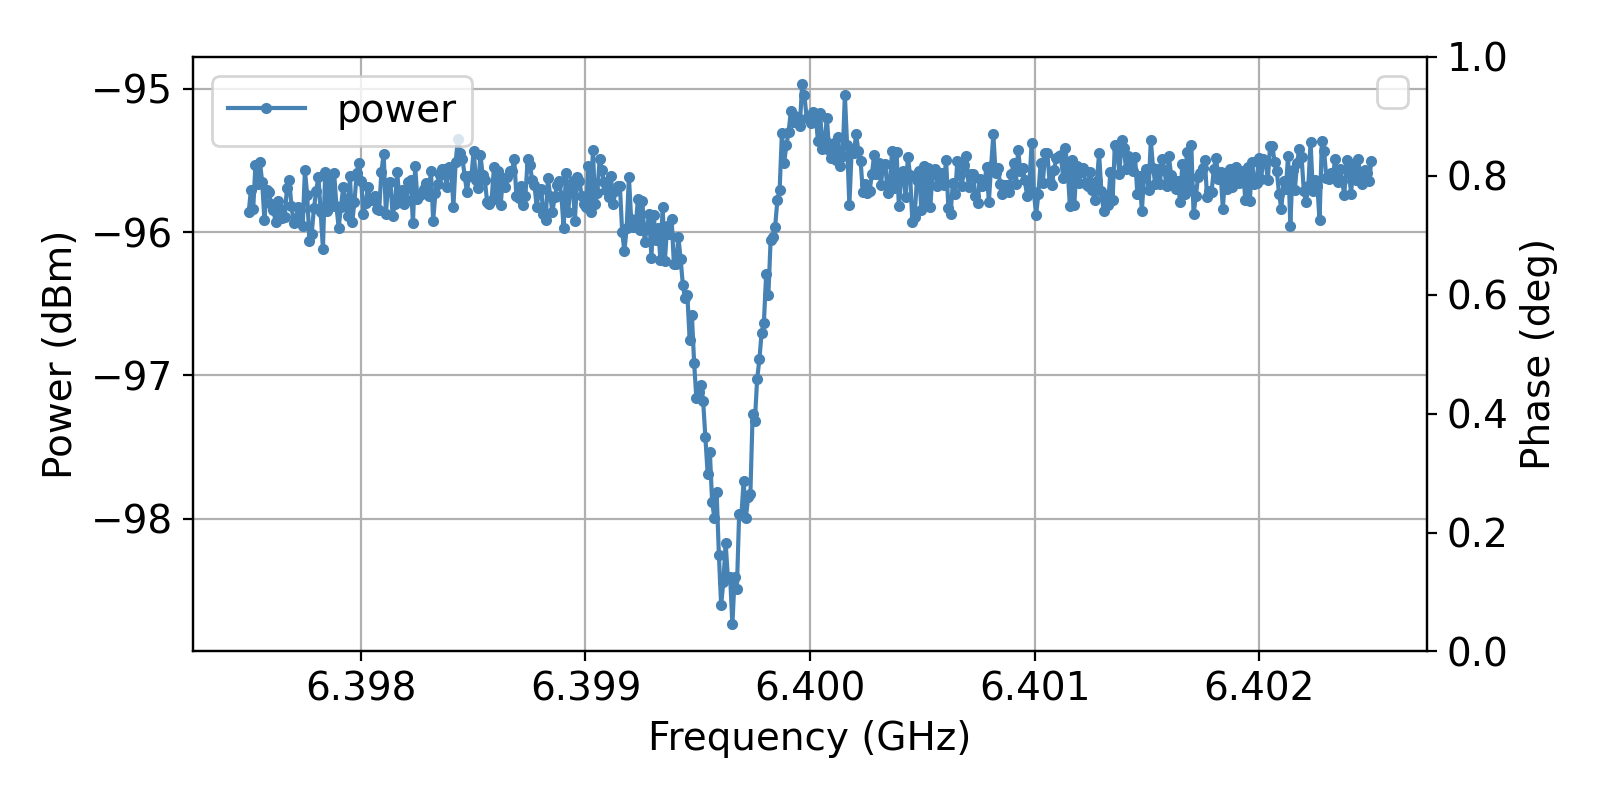

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [61]:
sweeper.envelope.enable(True)
sweeper.envelope.waveform(flat_top_gaussian)
sweeper.envelope.delay(envelope_delay)
sweeper.average.integration_delay(integration_delay)

# start measurement and plot
result = sweeper.run()
num_points_result = len(result["vector"])
print(f"Measured at {num_points_result} frequency points.")
plot_sweeper(np.linspace(ro_start_f, ro_stop_f, num_points) + ro_cent_f, result["vector"], unwrap = False, deg = True)
# sweeper.plot()
# plt.tight_layout()

## 2D sweep

### 2D sweep: frequency and amplitude of the digital oscillator (CW)

<IPython.core.display.Javascript object>


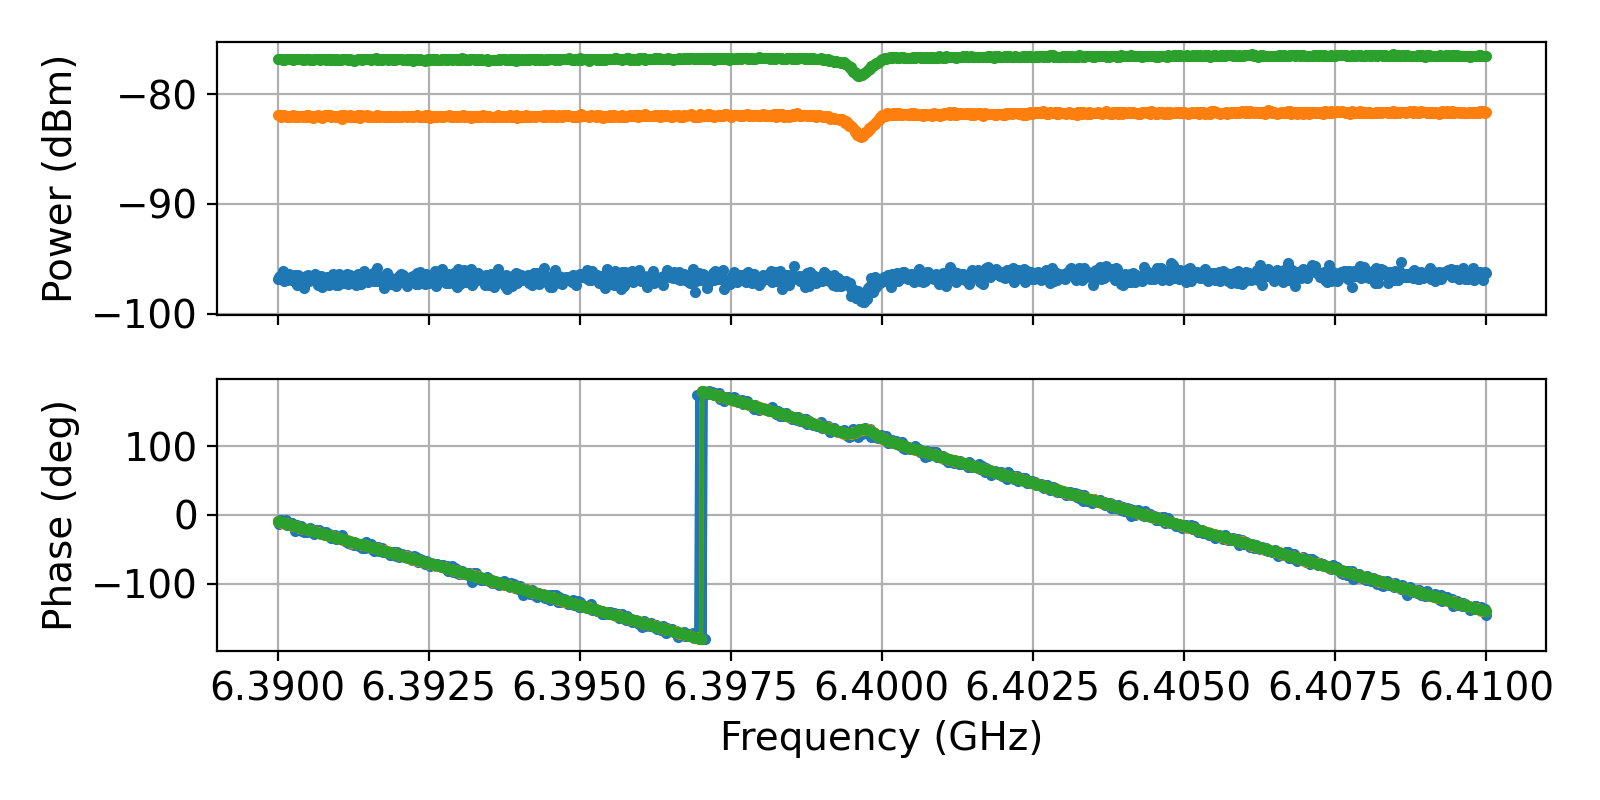

Run a sweep with 1000 frequency points in the range of [-10.0, 10.0] MHz + 6.4 GHz. 
Mapping is linear. 
Integration time = 2e-06 sec. 
Measures 2000 times per frequency point. 
Averaging mode is cyclic.
Trigger source is set to None, which means the sequencer defines the repetition rate.
Measurement (2000000/2000000) at -10.000MHz.                    
Run a sweep with 1000 frequency points in the range of [-10.0, 10.0] MHz + 6.4 GHz. 
Mapping is linear. 
Integration time = 2e-06 sec. 
Measures 2000 times per frequency point. 
Averaging mode is cyclic.
Trigger source is set to None, which means the sequencer defines the repetition rate.
Measurement (2000000/2000000) at -10.000MHz.                    
Run a sweep with 1000 frequency points in the range of [-10.0, 10.0] MHz + 6.4 GHz. 
Mapping is linear. 
Integration time = 2e-06 sec. 
Measures 2000 times per frequency point. 
Averaging mode is cyclic.
Trigger source is set to None, which means the sequencer defines the repetition rate.


<IPython.core.display.Javascript object>


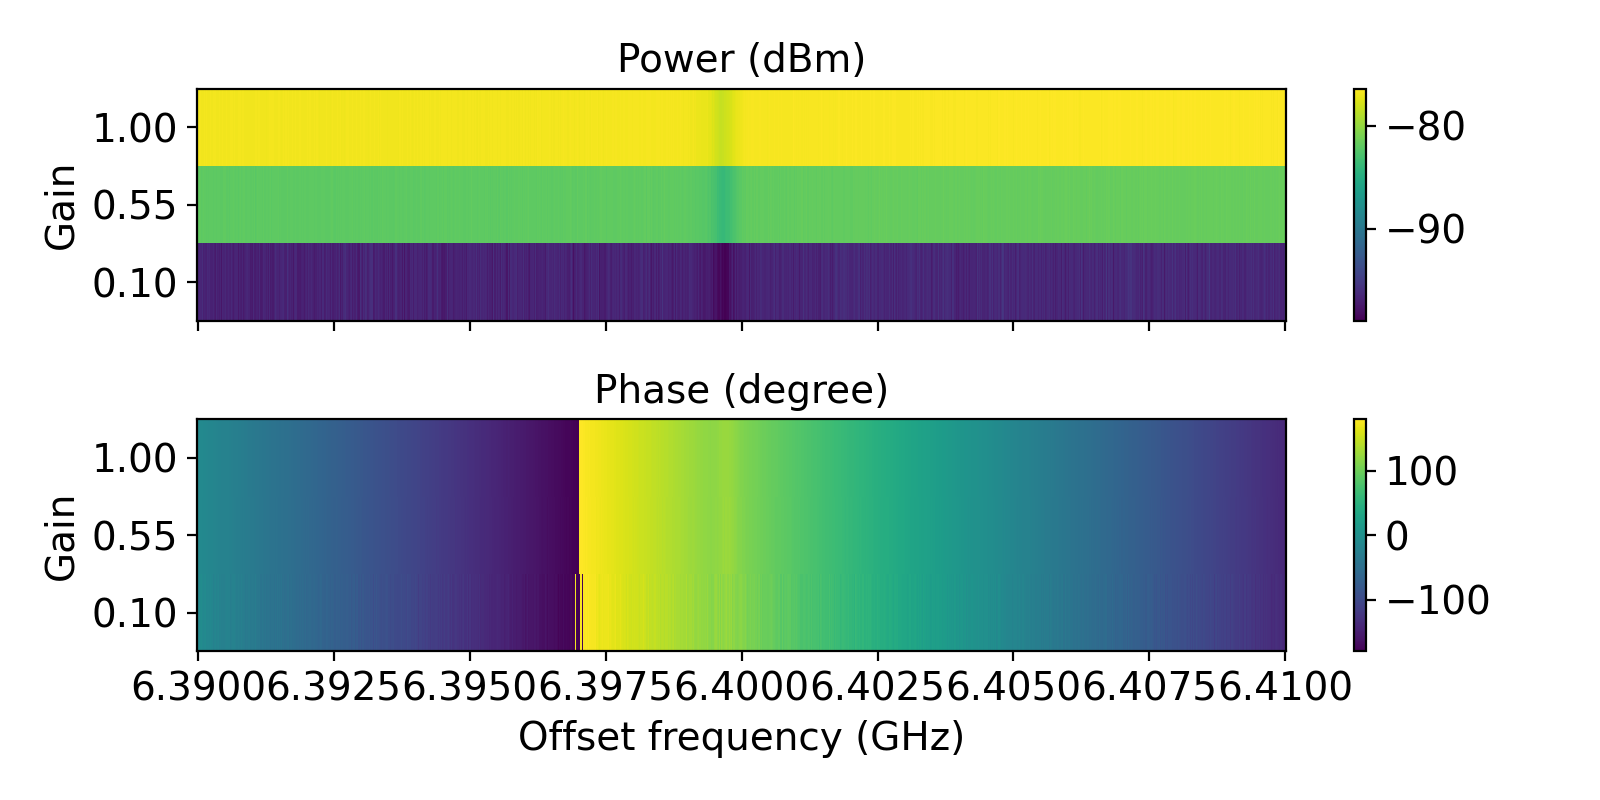

In [26]:
n = 3
ro_osc_gains = np.linspace(0.1, 1, n)

ro_f = np.linspace(ro_start_f, ro_stop_f, int(num_points)) + ro_cent_f
matrix = np.zeros([len(ro_osc_gains), num_points], dtype = np.complex_)
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)
for i in range(n):
    sweeper.envelope.enable(False)
    sweeper.sweep.oscillator_gain(ro_osc_gains[i])
    result = sweeper.run()
    matrix[i, :] = result['vector']
    
    ax0.plot(ro_f/1e9, 10*np.log10(np.abs(result['vector'])**2/50*1000), '.-', color = colors[i])
    ax1.plot(ro_f/1e9, np.angle(result['vector'], deg = True), '.-', color = colors[i])
    ax0.set_ylabel('Power (dBm)')
    ax1.set_ylabel('Phase (deg)')
    ax1.set_xlabel('Frequency (GHz)')
    ax0.grid()
    ax1.grid()
fig.tight_layout()
fig.align_ylabels([ax0, ax1])

plot_2d(ro_f/1e9, ro_osc_gains, matrix) 

### 2D sweep: frequency and amplitude of the digital oscillator (Pulsed)

<IPython.core.display.Javascript object>


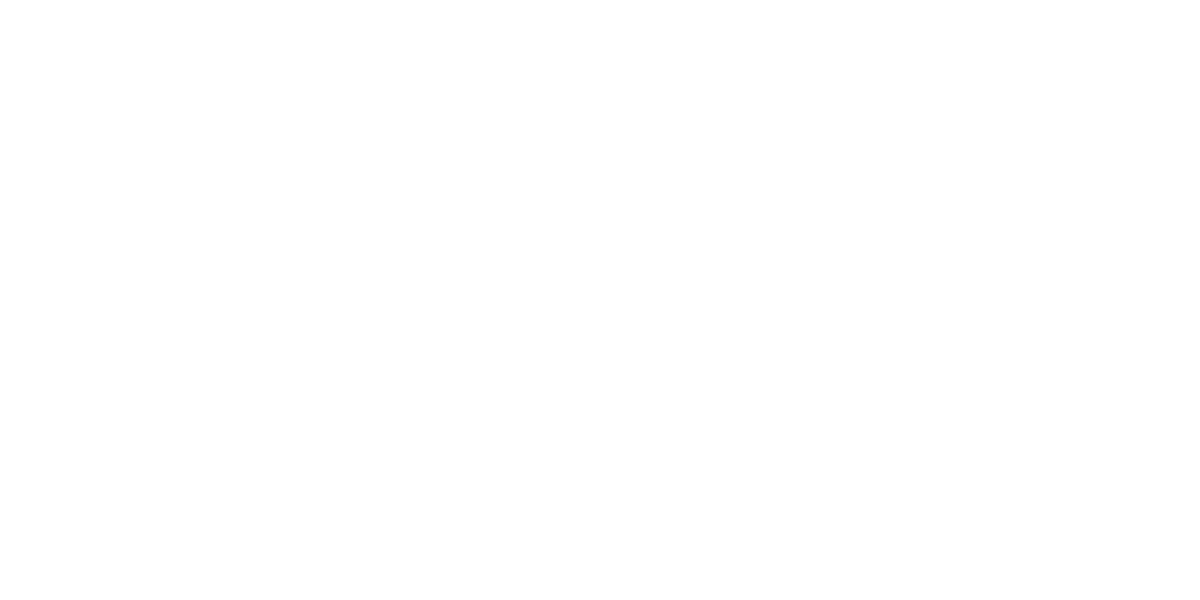

Run a sweep with 100 frequency points in the range of [-15.0, -5.0] MHz + 7.8 GHz. 
Mapping is linear. 
Integration time = 2e-06 sec. 
Measures 2000 times per frequency point. 
Averaging mode is cyclic.
Trigger source is set to None, which means the sequencer defines the repetition rate.
Measurement (200000/200000) at -15.000MHz.                    
Run a sweep with 100 frequency points in the range of [-15.0, -5.0] MHz + 7.8 GHz. 
Mapping is linear. 
Integration time = 2e-06 sec. 
Measures 2000 times per frequency point. 
Averaging mode is cyclic.
Trigger source is set to None, which means the sequencer defines the repetition rate.
Measurement (200000/200000) at -15.000MHz.                    
Run a sweep with 100 frequency points in the range of [-15.0, -5.0] MHz + 7.8 GHz. 
Mapping is linear. 
Integration time = 2e-06 sec. 
Measures 2000 times per frequency point. 
Averaging mode is cyclic.
Trigger source is set to None, which means the sequencer defines the repetition rate.
Measure

<IPython.core.display.Javascript object>


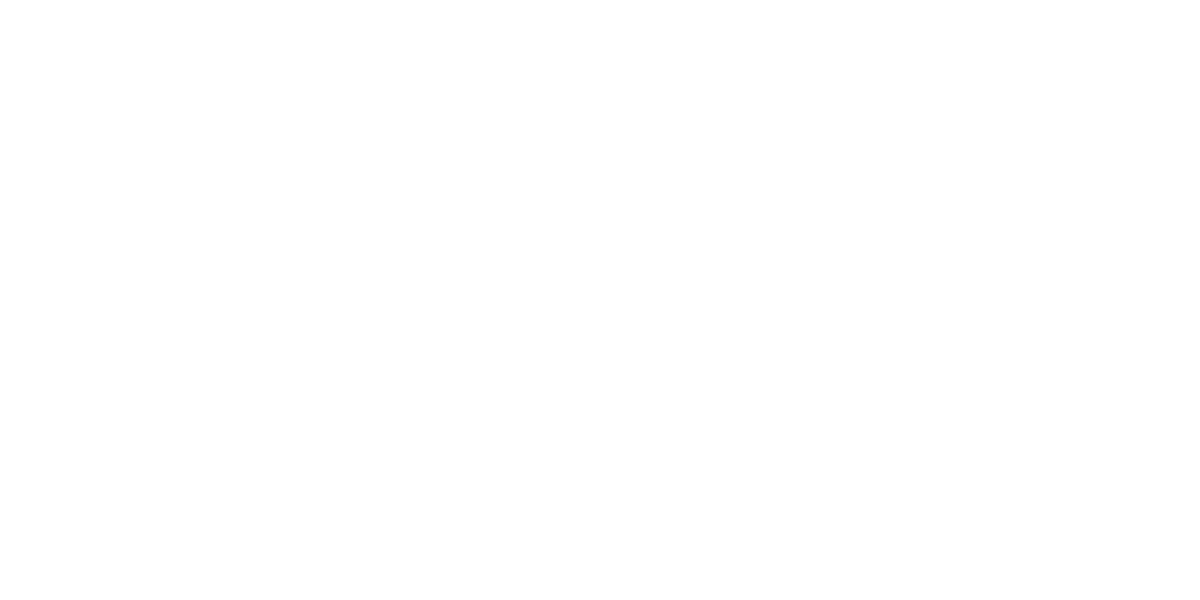

In [9]:
n = 3
ro_osc_gains = np.linspace(0.1, 1, n)

ro_f = np.linspace(ro_start_f, ro_stop_f, int(num_points)) + ro_cent_f
matrix = np.zeros([len(ro_osc_gains), num_points], dtype = np.complex_)
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)
for i in range(n):
    sweeper.envelope.enable(True)
    sweeper.sweep.oscillator_gain(ro_osc_gains[i])
    result = sweeper.run()
    matrix[i, :] = result['vector']
    
    ax0.plot(ro_f/1e9, 10*np.log10(np.abs(result['vector'])**2/50*1000), '.-', color = colors[i])
    ax1.plot(ro_f/1e9, np.angle(result['vector'], deg = True), '.-', color = colors[i])
    ax0.set_ylabel('Power (dBm)')
    ax1.set_ylabel('Phase (deg)')
    ax1.set_xlabel('Frequency (GHz)')
    ax0.grid()
    ax1.grid()
fig.tight_layout()
fig.align_ylabels([ax0, ax1])

plot_2d(ro_f/1e9, ro_osc_gains, matrix) 

# Qubit measurements (QA and SG channels)

## Set parameters

In [6]:
n_q = 1 # number of qubit

# ro_cent_f = 8e9 # range from 1 GHz - 8 GHz with 0.1 GHz granularity

# ro_df = np.linspace(-100.3249e6, -100.6e6, n_q)
ro_df = np.linspace((6.399646-6.5)*1e9, -100.6e6, n_q) # value extracted from longer integration time
# ro_df = np.linspace((6.399480-6.5)*1e9, -100.6e6, n_q) # value extracted from pulsed resonator

# ro_out_range = 0 # in dBm
# ro_in_range = 0  

ro_pulse_duration = envelope_duration # range from 0 - 2 us
ro_pulse_rise_fall_time = envelope_rise_fall_time
ro_pulse_phase = 0 # deg
weights_phase = 0
ro_pulse_amp = ro_osc_gain/n_q

integration_length = ro_pulse_duration
integration_delay = 324e-9
result_source = 1 # 1 integration, 3 thresholding
avg_mode = 1 # 0 cyclic, 1 sequential

dr_cent_f = np.linspace(3.9e9, 4.1e9, int(np.ceil(n_q/2)))
dr_df = np.ones(n_q) * 30e6
dr_out_range = np.ones(n_q) * (-7) # XY-control power
dr_pulse_duration = np.ones(n_q) * 1600e-9
dr_pulse_sigma = dr_pulse_duration/8
dr_pulse_beta = np.ones(n_q) * 0.2
dr_pulse_amp = np.ones(n_q) * 1
n_cpmg = 5

with device.set_transaction():
    device.qachannels[0].centerfreq(ro_cent_f)
    device.qachannels[0].output.range(ro_out_range)
    device.qachannels[0].input.range(ro_in_range)
    device.qachannels[0].output.on(1)
    device.qachannels[0].input.on(1)
    
    device.qachannels[0].mode(1) # 0 spectroscopy, 1 readout
    device.qachannels[0].readout.integration.length(int(integration_length * fs)) # in samples
    device.qachannels[0].readout.integration.delay(int(integration_delay)) # in second
    device.qachannels[0].readout.result.source(result_source)
    device.qachannels[0].readout.result.mode(avg_mode) # 0 cyclic, 1 sequential
    device.qachannels[0].readout.result.enable(0) 
    device.qachannels[0].generator.auxtriggers[0].channel('inttrig')
    device.qachannels[0].generator.enable(0)
    ct = {}
    for i in range(n_q):
        device.synthesizers[int(np.floor(i/2) + 1)].centerfreq(dr_cent_f[int(np.floor(i/2))]) # synthesizer ind for sg_ch is from 1
        device.sgchannels[i].output.range(dr_out_range[i])
        device.sgchannels[i].output.on(1)
        device.sgchannels[i].oscs[0].freq(dr_df[i])
        device.sgchannels[i].sines[0].i.sin.amplitude(0)
        device.sgchannels[i].sines[0].i.cos.amplitude(1)
        device.sgchannels[i].sines[0].q.sin.amplitude(1)
        device.sgchannels[i].sines[0].q.cos.amplitude(0)
        device.sgchannels[i].sines[0].i.enable(0)
        device.sgchannels[i].sines[0].q.enable(0)
        device.sgchannels[i].awg.outputs[0].gains[0](1)
        device.sgchannels[i].awg.outputs[1].gains[0](1)
        device.sgchannels[i].awg.outputs[0].gains[1](-1)
        device.sgchannels[i].awg.outputs[1].gains[1](1)
        device.sgchannels[i].awg.time(0) # set 2.0 GSa/s for all channels
        ct_schema = device.sgchannels[i].awg.commandtable.load_validation_schema()
        ct[i] = CommandTable(ct_schema)
        
        device.sgchannels[i].trigger.level(0.1)
        device.sgchannels[i].awg.auxtriggers[0].slope(1)
        device.sgchannels[i].awg.auxtriggers[0].channel('inttrig')
                
device.qachannels[0].generator.clearwave()
readout_pulses = upload_generate_readout_pulses(device, ro_pulse_duration, ro_pulse_rise_fall_time, ro_df, ro_pulse_phase, n_q, ro_pulse_amp)


device.qachannels[0].readout.integration.clearweight()
weights = Waveforms()
for waveform_slot, pulse in readout_pulses.items():
    weights.assign_waveform(waveform_slot, np.conj(pulse[0]) * np.exp(2j * np.pi * weights_phase)/np.abs(pulse[0]))
device.qachannels[0].readout.write_integration_weights(weights = weights, integration_delay = integration_delay)


In [11]:
weights[0]

(Wave([ 1.        +0.j        ,  0.74832638-0.6633307j ,
        0.11998476-0.99277573j, ..., -0.68060864-0.73264717j,
       -0.99530477-0.0967906j , -0.80901699+0.58778525j]),
 None,
 None)

## Qubit spectroscopy

### Continuous drive


 wait at least 32.4 seconds
 progress: 100%

<IPython.core.display.Javascript object>


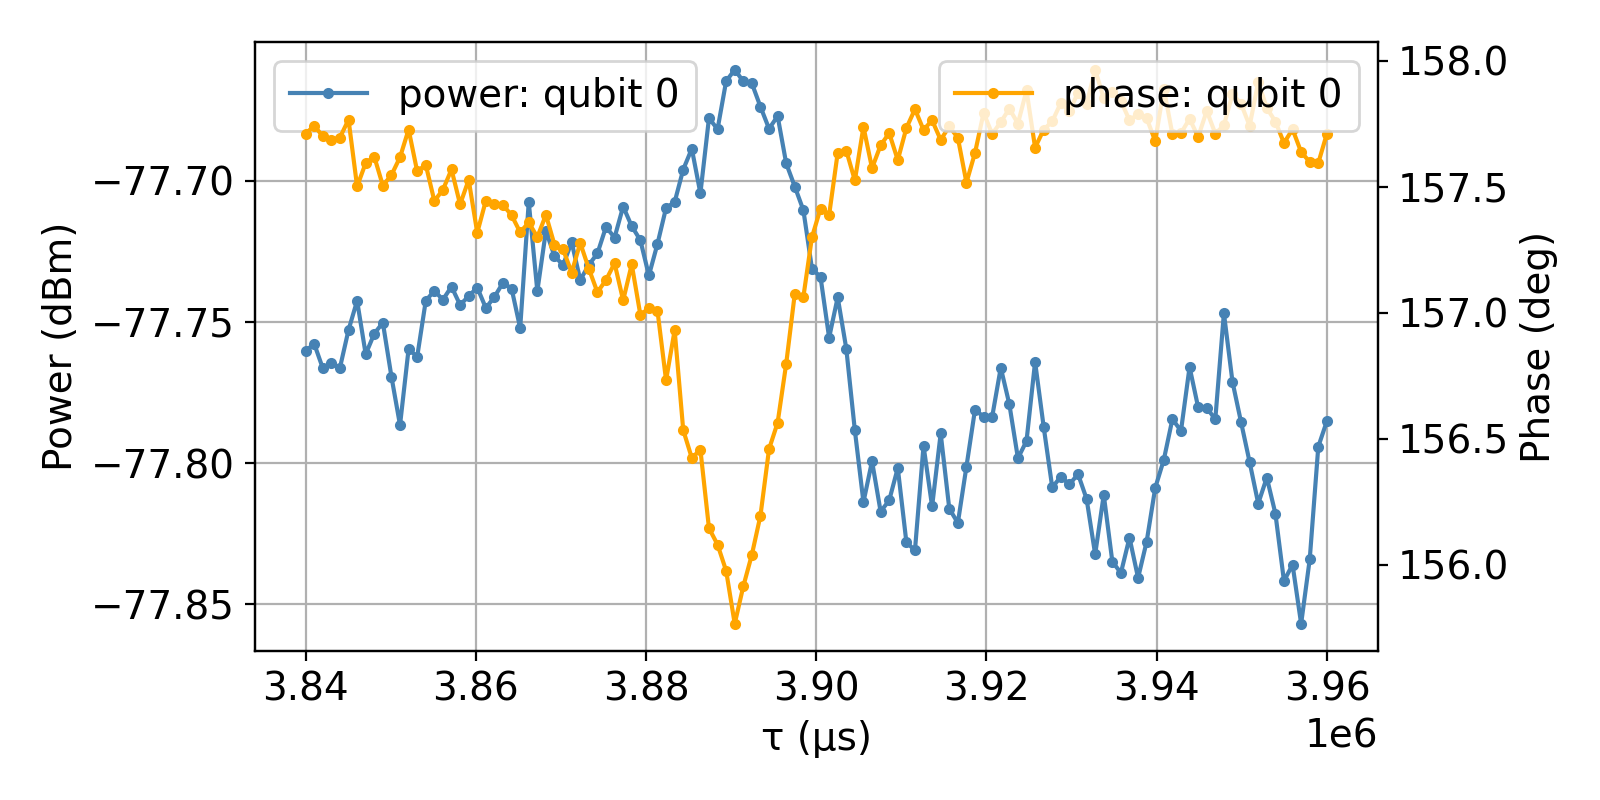

In [7]:
start = np.linspace(-60e6, 300e6, n_q)
stop = np.linspace(60e6, 60e6, n_q)
num_points = 120
num_avgs = 75000
delay_after_trigger = max(dr_pulse_duration) + 0e-6
cycle_time = delay_after_trigger + ro_pulse_duration + 0e-6 # incease a bit the cycle time when num_repeat is larger

seqc_qa = seqc_qubit_exp_qa(num_points, num_avgs, delay_after_trigger)
device.qachannels[0].generator.load_sequencer_program(seqc_qa)
device.qachannels[0].generator.enable_sequencer(single=True) 

with device.set_transaction():
    device.qachannels[0].readout.result.length(num_points)
    device.qachannels[0].readout.result.averages(num_avgs)
    device.qachannels[0].readout.result.enable(0)
    device.qachannels[0].readout.result.enable(1) # enable result logger
    for i in range(n_q):
        device.sgchannels[i].oscs[0].freq(start[i])
        device.sgchannels[i].sines[0].i.enable(1)
        device.sgchannels[i].sines[0].q.enable(1)
        device.sgchannels[i].sines[0].i.sin.amplitude(0)
        device.sgchannels[i].sines[0].i.cos.amplitude(dr_pulse_amp[i])
        device.sgchannels[i].sines[0].q.sin.amplitude(dr_pulse_amp[i])
        device.sgchannels[i].sines[0].q.cos.amplitude(0)
        upload_compile_seqc_sg(start[i], stop[i], num_points, num_avgs, avg_mode, dr_pulse_duration[i], 
                                                   delay_after_trigger, n_cpmg, 'qubit spec cw', True, device, i)
        device.sgchannels[i].awg.enable(1)
        
    device.system.internaltrigger.holdoff(np.max(cycle_time))
    device.system.internaltrigger.repetitions(int(num_points*num_avgs))
    
device.system.internaltrigger.enable(1)
print(f'\n wait at least {cycle_time*num_points*num_avgs} seconds')
progress = 0
while(progress<1):
    progress = device.system.internaltrigger.progress()
    sys.stdout.write(f'\r progress: {int(progress*100)}%')
    sys.stdout.flush()
    
readout_results = device.qachannels[0].readout.read(timeout = 10 * num_points*num_avgs/1e6)
# plot_readout_IQ(readout_results, n_q)
dr_f = np.zeros([n_q, num_points])
for i in range(n_q):
    dr_f = np.linspace(start[i], stop[i], num_points) + dr_cent_f[int(np.floor(i/2))]
plot_qubit_readout_amp_phase(int(integration_length*fs),dr_f, readout_results[0:n_q], exp = 'qubit spec')

### Pulsed drive


 wait at least 8.639999999999999 seconds
 progress: 100%

<IPython.core.display.Javascript object>


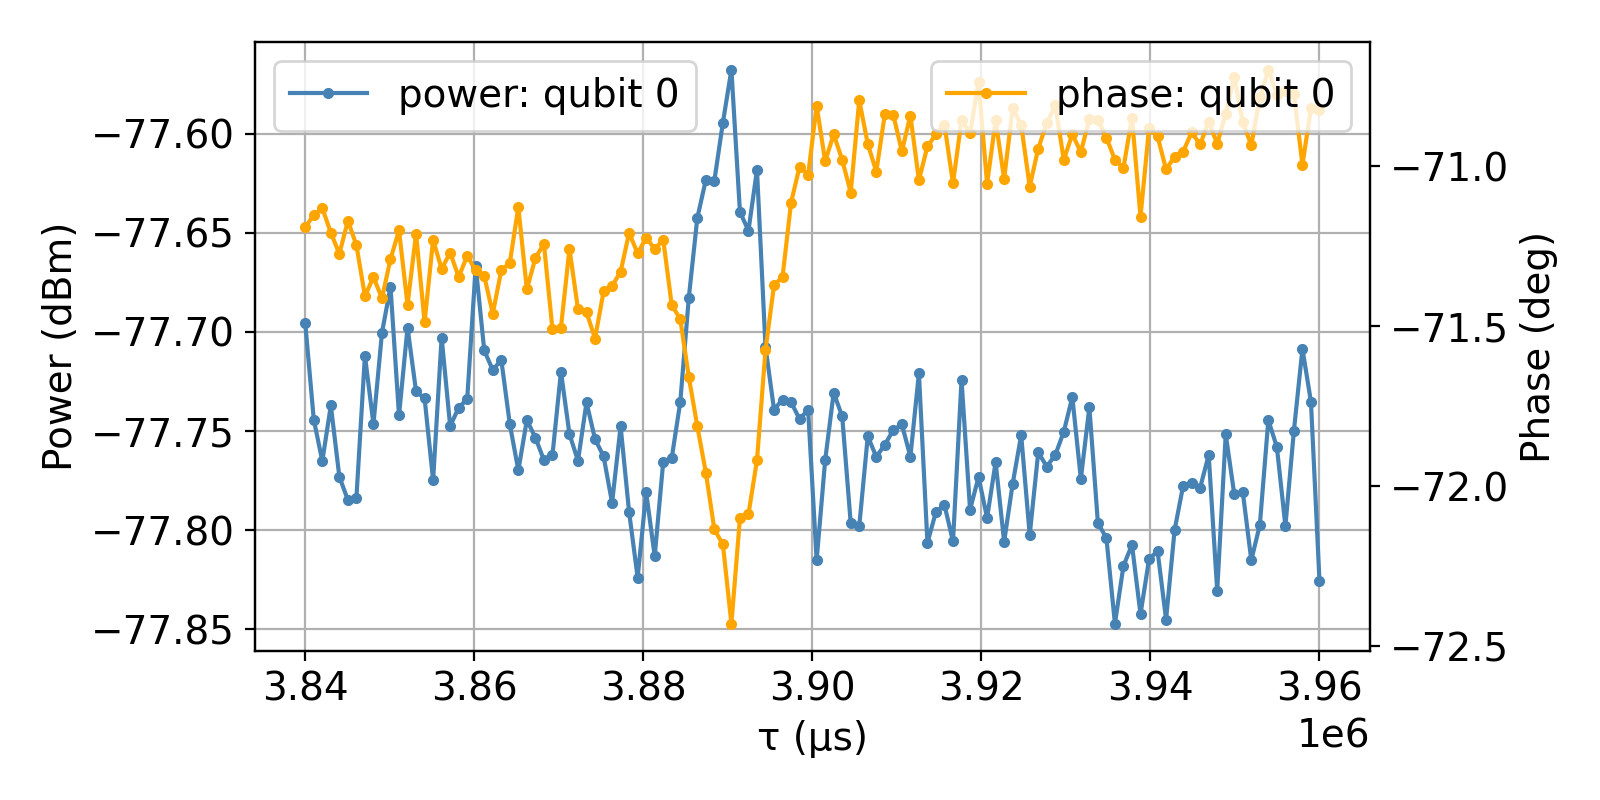

In [64]:
start = np.linspace(-60e6, -10e6, n_q)
stop = np.linspace(60e6, 60e6, n_q)
num_points = 120
num_avgs = 20000
delay_after_trigger = max(dr_pulse_duration) + 0e-6
cycle_time = delay_after_trigger + ro_pulse_duration + 0e-6
exp = 'qubit spec pulsed'
# dr_pulse_amp = np.ones(n_q) * 1

seqc_qa = seqc_qubit_exp_qa(num_points, num_avgs, delay_after_trigger)
device.qachannels[0].generator.load_sequencer_program(seqc_qa)
device.qachannels[0].generator.enable_sequencer(single=True) 

with device.set_transaction():
    device.qachannels[0].readout.result.length(num_points)
    device.qachannels[0].readout.result.averages(num_avgs)
    device.qachannels[0].readout.result.enable(1) # enable result logger
for i in range(n_q):
    device.sgchannels[i].oscs[0].freq(start[i])
    device.sgchannels[i].sines[0].i.enable(0)
    device.sgchannels[i].sines[0].q.enable(0)
    device.sgchannels[i].awg.modulation.enable(1)
    upload_compile_seqc_sg(start[i], stop[i], num_points, num_avgs, avg_mode, dr_pulse_duration[i], 
                                               delay_after_trigger, n_cpmg, exp, True, device, i)
    generate_upload_drive_drag_pulses(dr_pulse_duration[i], dr_pulse_sigma[i], dr_pulse_beta[i], 
                                                    dr_pulse_amp[i], True, device, i)
    upload_ct_sg(exp = exp, upload = True, device = device, channel_index = i)
    device.sgchannels[i].awg.enable(1)
    
device.system.internaltrigger.holdoff(np.max(cycle_time))
device.system.internaltrigger.repetitions(int(num_points*num_avgs))   
device.system.internaltrigger.enable(1)
    
print(f'\n wait at least {cycle_time*num_points*num_avgs} seconds')
progress = 0
while(progress<1):
    progress = device.system.internaltrigger.progress()
    sys.stdout.write(f'\r progress: {int(progress*100)}%')
    sys.stdout.flush()
    
readout_results = device.qachannels[0].readout.read()
dr_f = np.zeros([n_q, num_points])
for i in range(n_q):
    dr_f = np.linspace(start[i], stop[i], num_points) + dr_cent_f[int(np.floor(i/2))]
plot_qubit_readout_amp_phase(int(integration_length*fs),dr_f, readout_results[0:n_q], exp = exp)

## Rabi (sweep amplitude)

average mode is set to cyclic

 wait at least 79.2 seconds
 progress: 100%

<IPython.core.display.Javascript object>


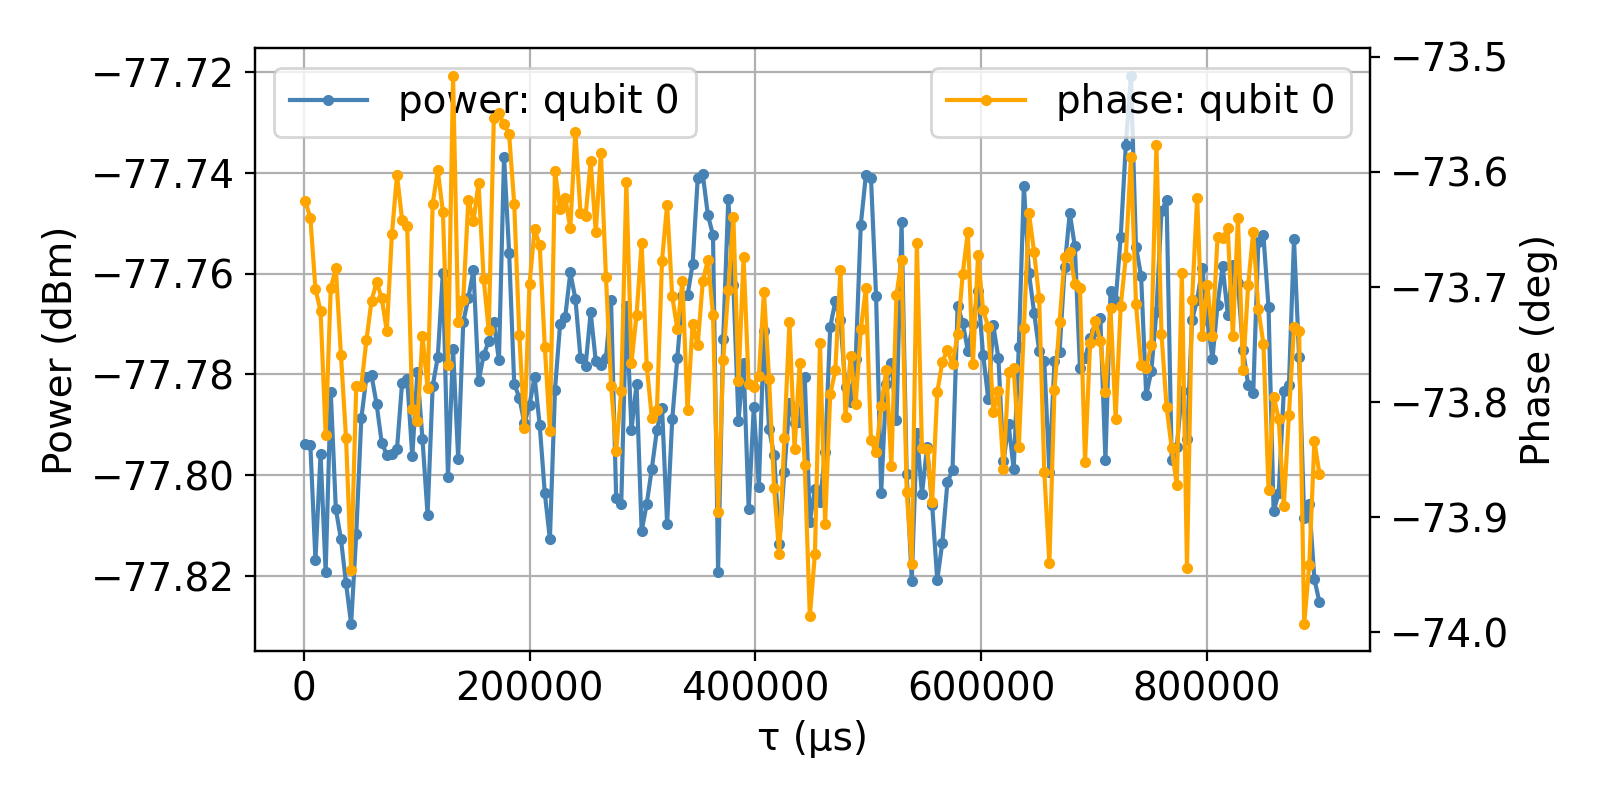

In [62]:
dr_df = np.ones(n_q) * (3.8914-3.9)*1e9 # qubit offset frequency
start = np.linspace(0.001, 0.001, n_q)
stop = np.linspace(0.9, 0.9, n_q)
num_points = 200
num_avgs = 60000
delay_after_trigger = max(dr_pulse_duration) + 1e-6
cycle_time = delay_after_trigger + ro_pulse_duration + 2e-6
exp = 'rabi da'
# dr_pulse_amp = np.ones(n_q) * 1

seqc_qa = seqc_qubit_exp_qa(num_points, num_avgs, delay_after_trigger)
device.qachannels[0].generator.load_sequencer_program(seqc_qa)
device.qachannels[0].generator.enable_sequencer(single=True) 

with device.set_transaction():
    device.qachannels[0].readout.result.length(num_points)
    device.qachannels[0].readout.result.averages(num_avgs)
    device.qachannels[0].readout.result.enable(1) # enable result logger
for i in range(n_q):
    device.sgchannels[i].oscs[0].freq(dr_df[i])
    device.sgchannels[i].sines[0].i.enable(0)
    device.sgchannels[i].sines[0].q.enable(0)
    device.sgchannels[i].awg.modulation.enable(1)
    upload_compile_seqc_sg(start[i], stop[i], num_points, num_avgs, avg_mode, dr_pulse_duration[i], 
                                               delay_after_trigger, n_cpmg, exp, True, device, i)
    generate_upload_drive_drag_pulses(dr_pulse_duration[i], dr_pulse_sigma[i], dr_pulse_beta[i], 
                                                    dr_pulse_amp[i], True, device, i)
    upload_ct_sg(start[i], stop[i], num_points, exp = exp, upload = True, device = device, channel_index = i)
    device.sgchannels[i].awg.enable(1)
    
device.system.internaltrigger.holdoff(np.max(cycle_time))
device.system.internaltrigger.repetitions(int(num_points*num_avgs))   
device.system.internaltrigger.enable(1)
    
print(f'\n wait at least {cycle_time*num_points*num_avgs} seconds')
progress = 0
while(progress<1):
    progress = device.system.internaltrigger.progress()
    sys.stdout.write(f'\r progress: {int(progress*100)}%')
    sys.stdout.flush()
    
readout_results = device.qachannels[0].readout.read(timeout = 100 * num_points/50)
dr_amp_sfactor = np.zeros([n_q, num_points])
for i in range(n_q):
    dr_amp_sfactor = np.linspace(start[i], stop[i], num_points)
plot_qubit_readout_amp_phase(int(integration_length*fs),dr_amp_sfactor, readout_results[0:n_q], exp = exp)

### Rabi (sweep duration, tbd)


 wait at least 16.000000000000004 seconds
 progress: 100%

<IPython.core.display.Javascript object>


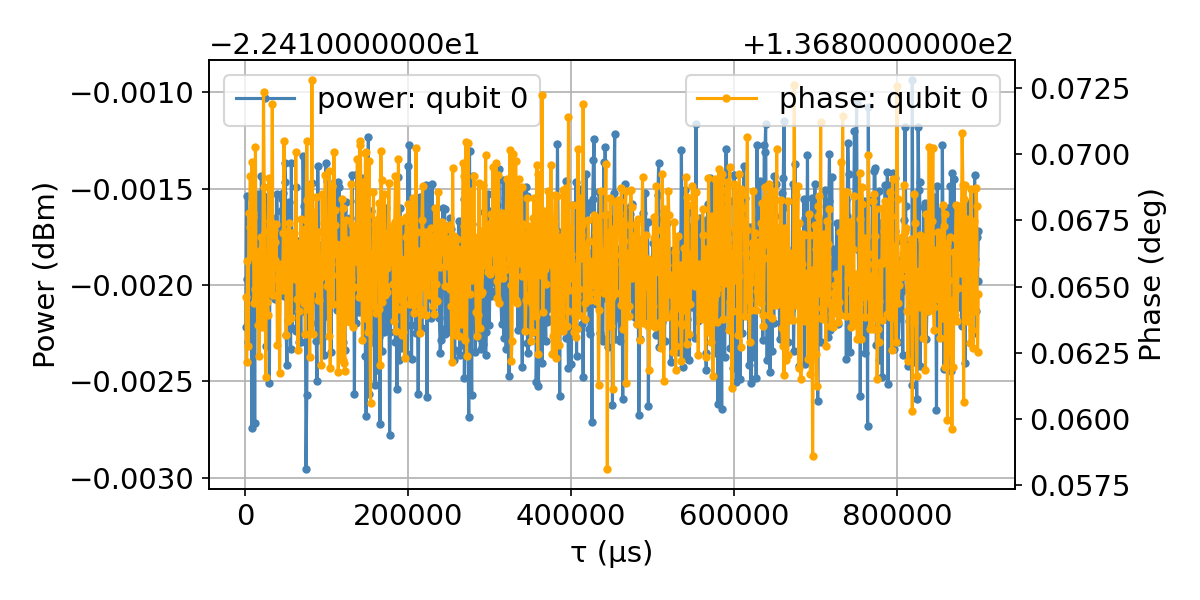

<IPython.core.display.Javascript object>


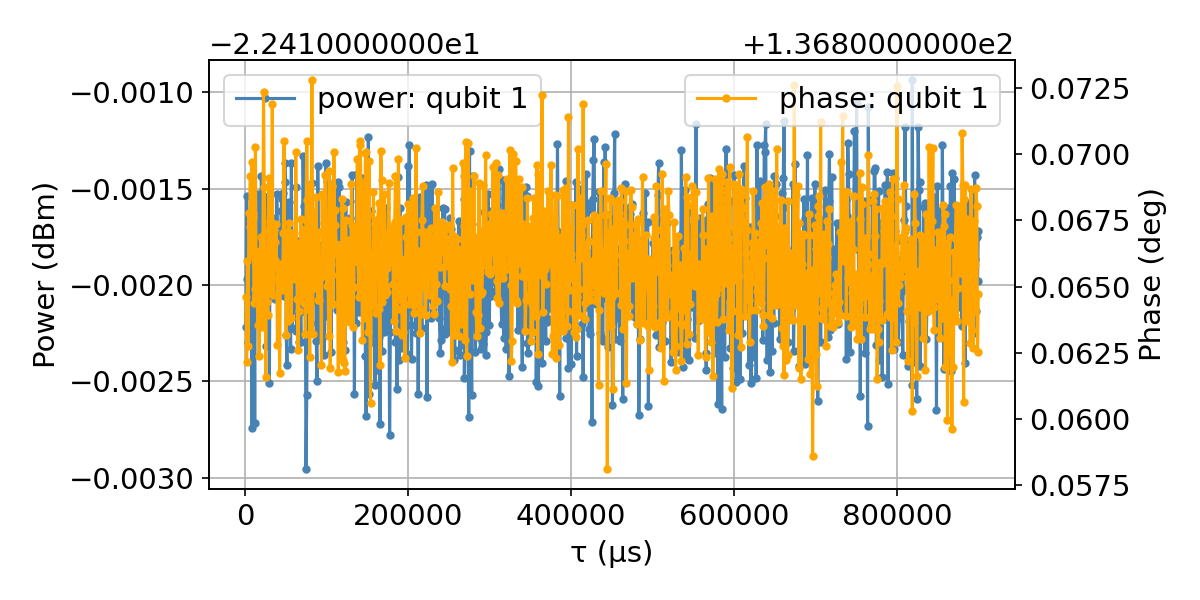

In [17]:
dr_df = np.ones(n_q) * 50e6
start = np.linspace(16e-9, 0.001, n_q)
stop = np.linspace(16e-9, 0.9, n_q)
num_points = 1000
num_avgs = 2000
delay_after_trigger = 1e-6
cycle_time = delay_after_trigger + ro_pulse_duration + 5e-6
exp = 'rabi da'


seqc_qa = seqc_qubit_exp_qa(num_points, num_avgs, delay_after_trigger)
device.qachannels[0].generator.load_sequencer_program(seqc_qa)
device.qachannels[0].generator.enable_sequencer(single=True) 

with device.set_transaction():
    device.qachannels[0].readout.result.length(num_points)
    device.qachannels[0].readout.result.averages(num_avgs)
    device.qachannels[0].readout.result.enable(1) # enable result logger
for i in range(n_q):
    device.sgchannels[i].oscs[0].freq(dr_df[i])
    device.sgchannels[i].sines[0].i.enable(0)
    device.sgchannels[i].sines[0].q.enable(0)
    device.sgchannels[i].awg.modulation.enable(1)
    upload_compile_seqc_sg(start[i], stop[i], num_points, num_avgs, avg_mode, dr_pulse_duration[i], 
                                               delay_after_trigger, n_cpmg, exp, True, device, i)
    generate_upload_drive_drag_pulses(dr_pulse_duration[i], dr_pulse_sigma[i], dr_pulse_beta[i], 
                                                    dr_pulse_amp[i], True, device, i)
    upload_ct_sg(exp = exp, upload = True, device = device, channel_index = i)
    device.sgchannels[i].awg.enable(1)
    
device.system.internaltrigger.holdoff(np.max(cycle_time))
device.system.internaltrigger.repetitions(int(num_points*num_avgs))   
device.system.internaltrigger.enable(1)
    
print(f'\n wait at least {cycle_time*num_points*num_avgs} seconds')
progress = 0
while(progress<1):
    progress = device.system.internaltrigger.progress()
    sys.stdout.write(f'\r progress: {int(progress*100)}%')
    sys.stdout.flush()
    
readout_results = device.qachannels[0].readout.read()
dr_amp_sfactor = np.zeros([n_q, num_points])
for i in range(n_q):
    dr_amp_sfactor = np.linspace(start[i], stop[i], num_points)
plot_qubit_readout_amp_phase(int(integration_length*fs),dr_amp_sfactor, readout_results[0:n_q], exp = exp)

## T1 measurement

3 points, step 492.0 ns

 wait at least 0.0312 seconds
 progress: 100%

<IPython.core.display.Javascript object>


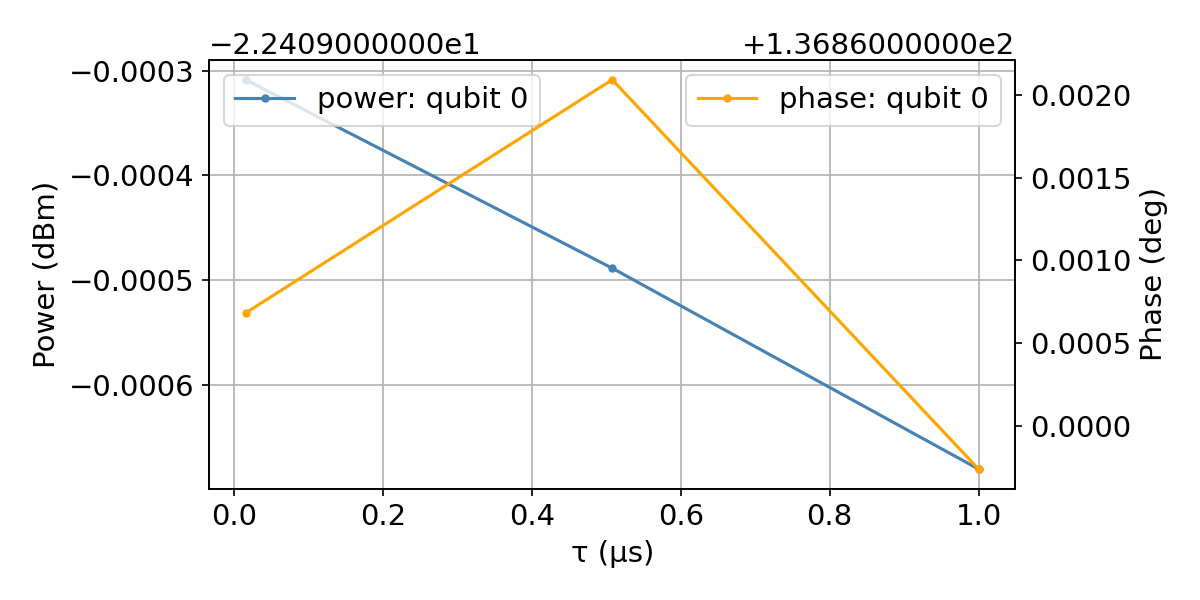

<IPython.core.display.Javascript object>


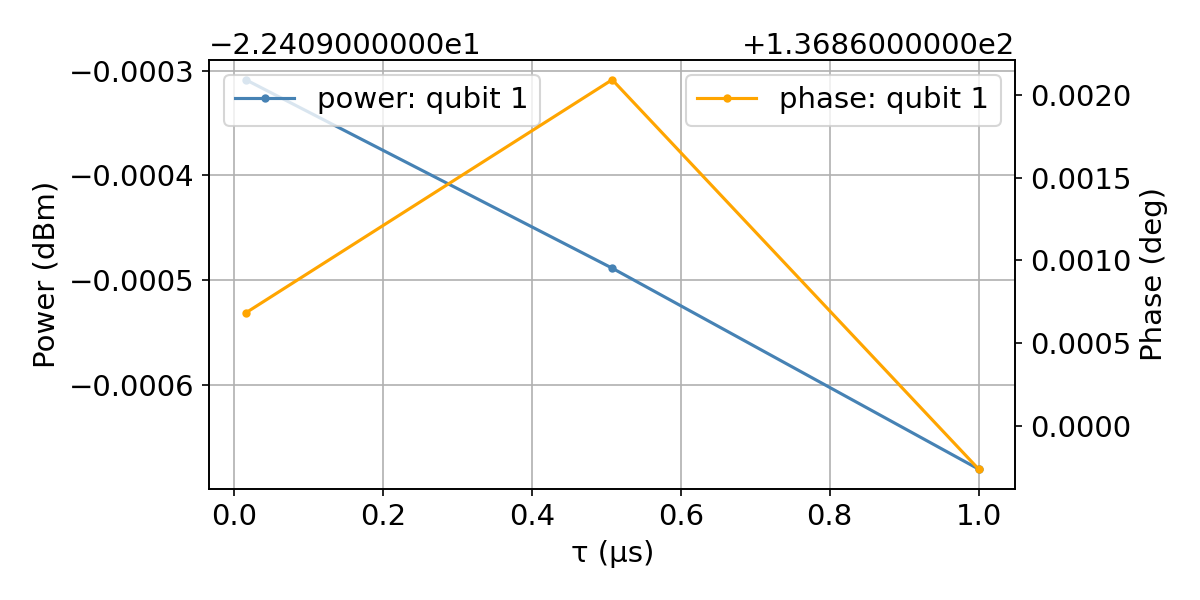

In [18]:
dr_pi_amp = np.ones(n_q) * 1 # pi pulse
dr_pulse_amp = dr_pi_amp 
dr_df = np.ones(n_q) * 50e6
start = np.ones(n_q) * 16e-9
stop = np.ones(n_q) * 1e-6
step = 8e-9 * 70
num_points = int(np.ceil(max(stop - start)/step + 1))
print(f'{num_points} points, step {max(stop-start)/(num_points-1)*1e9} ns')
num_avgs = 2000
delay_after_trigger = max(stop) + max(dr_pulse_duration) + 1e-6
cycle_time = delay_after_trigger + ro_pulse_duration + 1e-6
exp = 't1'

seqc_qa = seqc_qubit_exp_qa(num_points, num_avgs, delay_after_trigger)
device.qachannels[0].generator.load_sequencer_program(seqc_qa)
device.qachannels[0].generator.enable_sequencer(single=True) 

with device.set_transaction():
    device.qachannels[0].readout.result.length(num_points)
    device.qachannels[0].readout.result.averages(num_avgs)
    device.qachannels[0].readout.result.enable(1) # enable result logger
for i in range(n_q):
    device.sgchannels[i].oscs[0].freq(dr_df[i])
    device.sgchannels[i].sines[0].i.enable(0)
    device.sgchannels[i].sines[0].q.enable(0)
    device.sgchannels[i].awg.modulation.enable(1)
    upload_compile_seqc_sg(start[i], stop[i], num_points, num_avgs, avg_mode, dr_pulse_duration[i], 
                                               delay_after_trigger, n_cpmg, exp, True, device, i)
    generate_upload_drive_drag_pulses(dr_pulse_duration[i], dr_pulse_sigma[i], dr_pulse_beta[i], 
                                                    dr_pulse_amp[i], True, device, i)
    upload_ct_sg(exp = exp, upload = True, device = device, channel_index = i)
    device.sgchannels[i].awg.enable(1)
    
device.system.internaltrigger.holdoff(np.max(cycle_time))
device.system.internaltrigger.repetitions(int(num_points*num_avgs))   
device.system.internaltrigger.enable(1)
    
print(f'\n wait at least {cycle_time*num_points*num_avgs} seconds')
progress = 0
while(progress<1):
    progress = device.system.internaltrigger.progress()
    sys.stdout.write(f'\r progress: {int(progress*100)}%')
    sys.stdout.flush()
    
readout_results = device.qachannels[0].readout.read(timeout = num_points/50)
x = np.zeros([n_q, num_points])
for i in range(n_q):
    x = np.linspace(start[i], stop[i], num_points)
plot_qubit_readout_amp_phase(int(integration_length*fs),x, readout_results[0:n_q], exp = exp)

## T2 Measurement 

### T2 measurement (Ramsey)

3 points, step 492.0 ns

 wait at least 0.0324 seconds
 progress: 100%

<IPython.core.display.Javascript object>


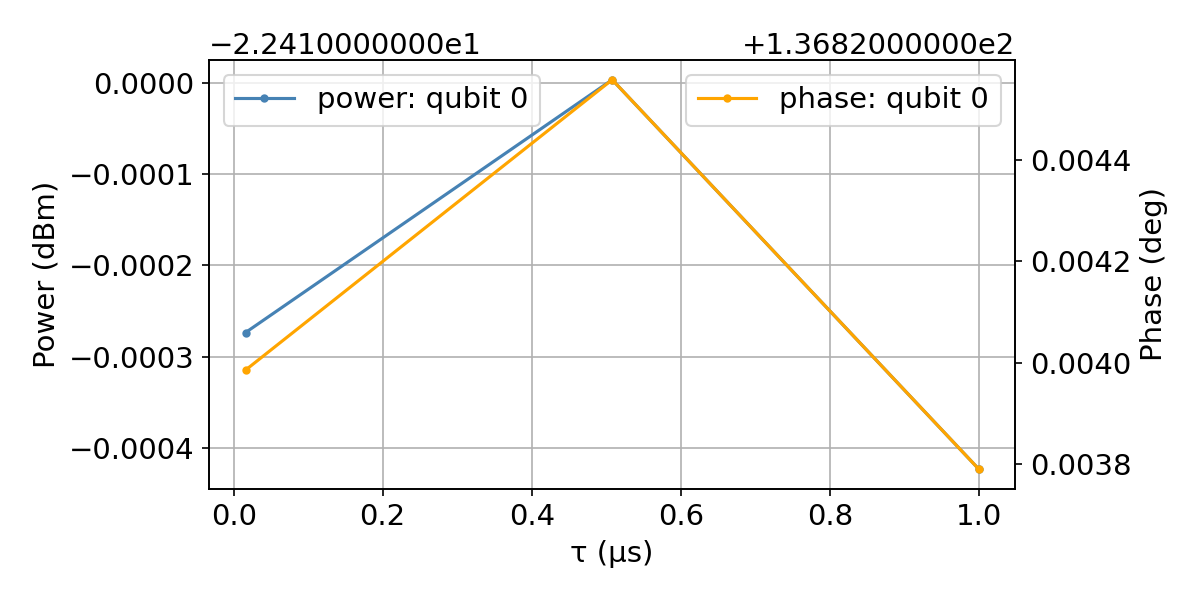

<IPython.core.display.Javascript object>


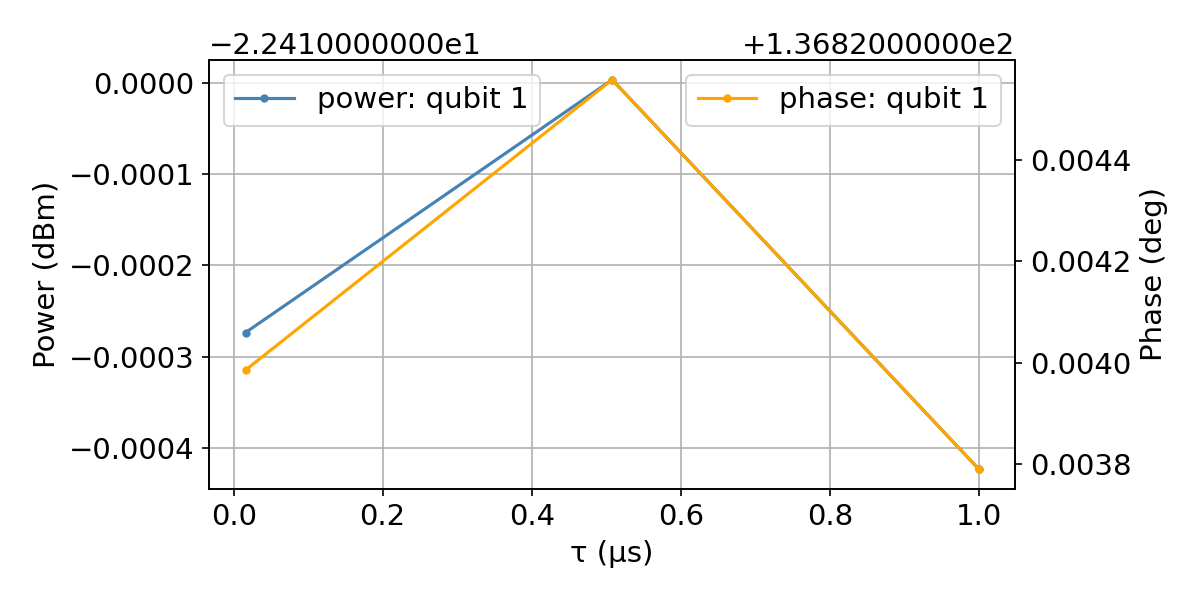

In [19]:
dr_pulse_amp = dr_pi_amp # pi/2 pulse is configured by command table with amplitude factor of 0.5
dr_df = np.ones(n_q) * 50e6
start = np.ones(n_q) * 16e-9
stop = np.ones(n_q) * 1e-6
step = 8e-9 * 70
num_points = int(np.ceil(max(stop - start)/step + 1))
print(f'{num_points} points, step {max(stop-start)/(num_points-1)*1e9} ns')
num_avgs = 2000
delay_after_trigger = max(stop) + 2 * max(dr_pulse_duration) + 1e-6
cycle_time = delay_after_trigger + ro_pulse_duration + 1e-6
exp = 'ramsey'

seqc_qa = seqc_qubit_exp_qa(num_points, num_avgs, delay_after_trigger)
device.qachannels[0].generator.load_sequencer_program(seqc_qa)
device.qachannels[0].generator.enable_sequencer(single=True) 

with device.set_transaction():
    device.qachannels[0].readout.result.length(num_points)
    device.qachannels[0].readout.result.averages(num_avgs)
    device.qachannels[0].readout.result.enable(1) # enable result logger
for i in range(n_q):
    device.sgchannels[i].oscs[0].freq(dr_df[i])
    device.sgchannels[i].sines[0].i.enable(0)
    device.sgchannels[i].sines[0].q.enable(0)
    device.sgchannels[i].awg.modulation.enable(1)
    upload_compile_seqc_sg(start[i], stop[i], num_points, num_avgs, avg_mode, dr_pulse_duration[i], 
                                               delay_after_trigger, n_cpmg, exp, True, device, i)
    generate_upload_drive_drag_pulses(dr_pulse_duration[i], dr_pulse_sigma[i], dr_pulse_beta[i], 
                                                    dr_pulse_amp[i], True, device, i)
    upload_ct_sg(exp = exp, upload = True, device = device, channel_index = i)
    device.sgchannels[i].awg.enable(1)
    
device.system.internaltrigger.holdoff(np.max(cycle_time))
device.system.internaltrigger.repetitions(int(num_points*num_avgs))   
device.system.internaltrigger.enable(1)
    
print(f'\n wait at least {cycle_time*num_points*num_avgs} seconds')
progress = 0
while(progress<1):
    progress = device.system.internaltrigger.progress()
    sys.stdout.write(f'\r progress: {int(progress*100)}%')
    sys.stdout.flush()
    
readout_results = device.qachannels[0].readout.read(timeout = num_points/50)
x = np.zeros([n_q, num_points])
for i in range(n_q):
    x = np.linspace(start[i], stop[i], num_points)
plot_qubit_readout_amp_phase(int(integration_length*fs),x, readout_results[0:n_q], exp = exp)

### T2 measurement (Hanh Echo)

3 points, step 492.0 ns

 wait at least 0.0336 seconds
 progress: 100%

<IPython.core.display.Javascript object>


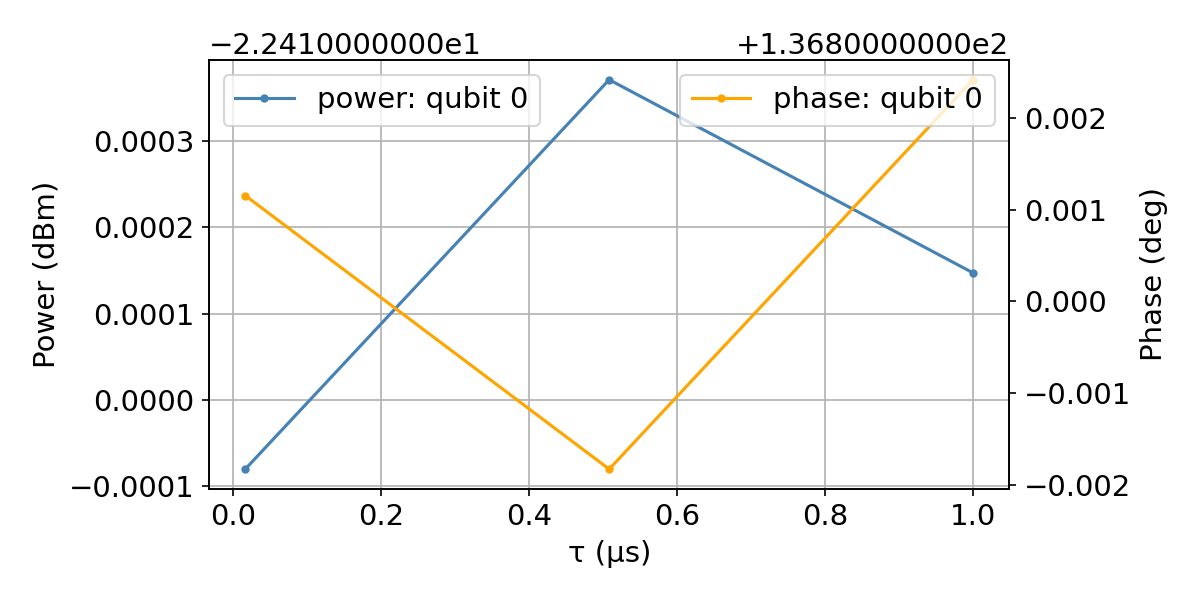

C:\Users\chunyans\Anaconda3\lib\site-packages\ipykernel_launcher.py:393: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


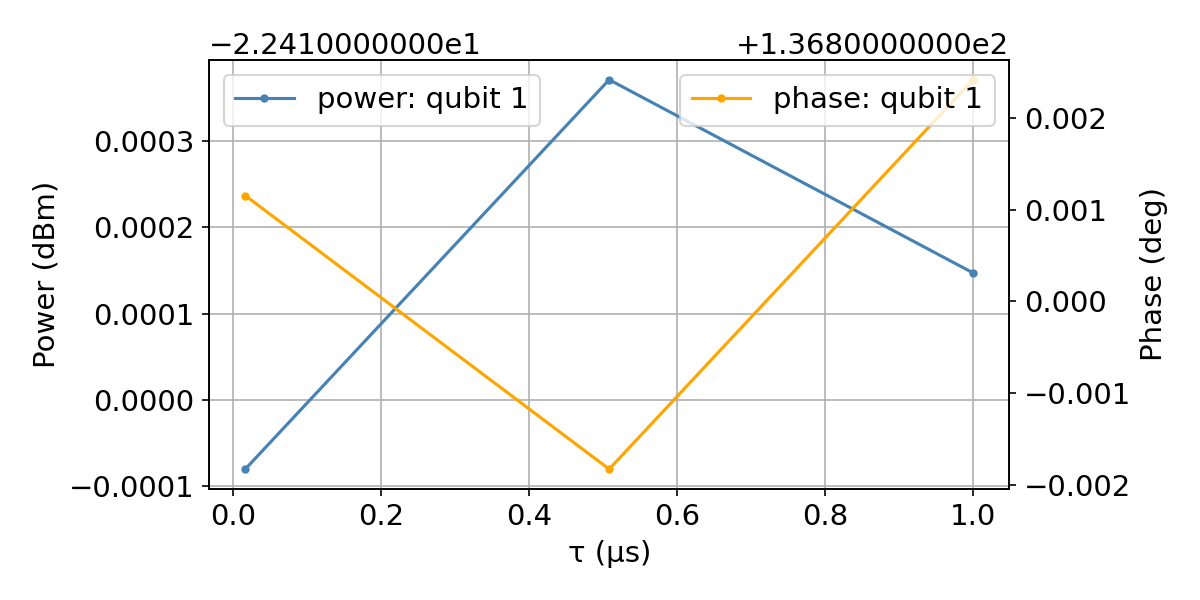

In [20]:
dr_pulse_amp = dr_pi_amp # pi/2 pulse is configured by command table with amplitude factor of 0.5
dr_df = np.ones(n_q) * 50e6
start = np.ones(n_q) * 16e-9
stop = np.ones(n_q) * 1e-6
step = 8e-9 * 70
num_points = int(np.ceil(max(stop - start)/step + 1))
print(f'{num_points} points, step {max(stop-start)/(num_points-1)*1e9} ns')
num_avgs = 2000
delay_after_trigger = 2 * max(stop) + 3 * max(dr_pulse_duration) + 0e-6
cycle_time = delay_after_trigger + ro_pulse_duration + 1e-6
exp = 'hanh echo'

seqc_qa = seqc_qubit_exp_qa(num_points, num_avgs, delay_after_trigger)
device.qachannels[0].generator.load_sequencer_program(seqc_qa)
device.qachannels[0].generator.enable_sequencer(single=True) 

with device.set_transaction():
    device.qachannels[0].readout.result.length(num_points)
    device.qachannels[0].readout.result.averages(num_avgs)
    device.qachannels[0].readout.result.enable(1) # enable result logger
for i in range(n_q):
    device.sgchannels[i].oscs[0].freq(dr_df[i])
    device.sgchannels[i].sines[0].i.enable(0)
    device.sgchannels[i].sines[0].q.enable(0)
    device.sgchannels[i].awg.modulation.enable(1)
    upload_compile_seqc_sg(start[i], stop[i], num_points, num_avgs, avg_mode, dr_pulse_duration[i], 
                                               delay_after_trigger, n_cpmg, exp, True, device, i)
    generate_upload_drive_drag_pulses(dr_pulse_duration[i], dr_pulse_sigma[i], dr_pulse_beta[i], 
                                                    dr_pulse_amp[i], True, device, i)
    upload_ct_sg(exp = exp, upload = True, device = device, channel_index = i)
    device.sgchannels[i].awg.enable(1)
    
device.system.internaltrigger.holdoff(np.max(cycle_time))
device.system.internaltrigger.repetitions(int(num_points*num_avgs))   
device.system.internaltrigger.enable(1)
    
print(f'\n wait at least {cycle_time*num_points*num_avgs} seconds')
progress = 0
while(progress<1):
    progress = device.system.internaltrigger.progress()
    sys.stdout.write(f'\r progress: {int(progress*100)}%')
    sys.stdout.flush()
    
readout_results = device.qachannels[0].readout.read(timeout = num_points/50)
x = np.zeros([n_q, num_points])
for i in range(n_q):
    x = np.linspace(start[i], stop[i], num_points)
plot_qubit_readout_amp_phase(int(integration_length*fs),x, readout_results[0:n_q], exp = exp)

### T2 measurement (CPMG)

3 points, step 241.99999999999997 ns

 wait at least 0.03 seconds
 progress: 100%

<IPython.core.display.Javascript object>


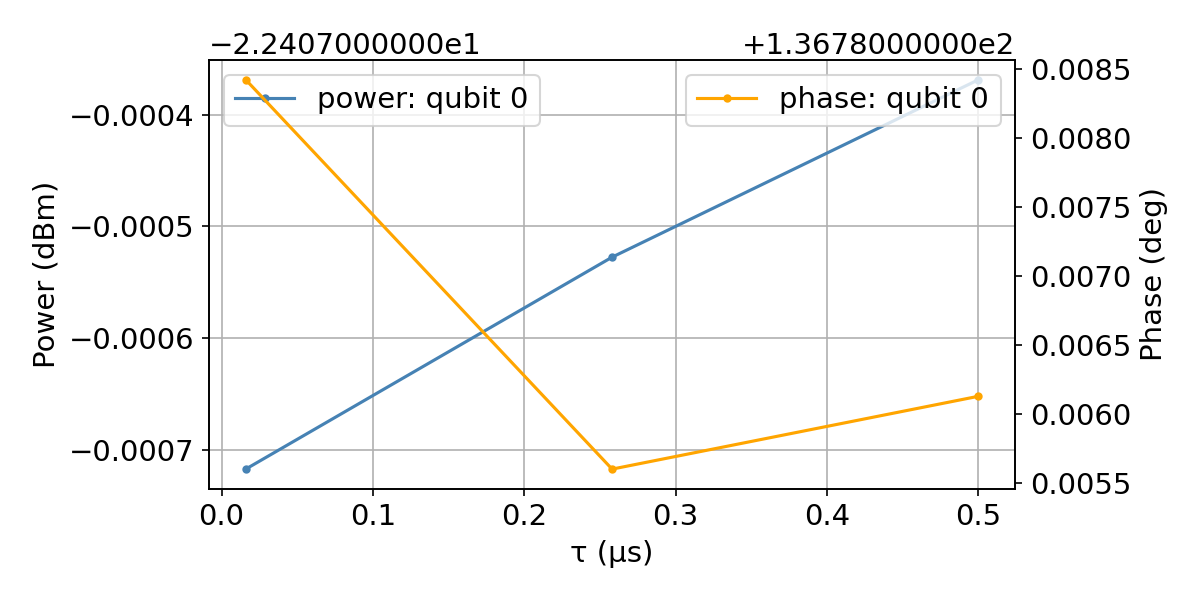

<IPython.core.display.Javascript object>


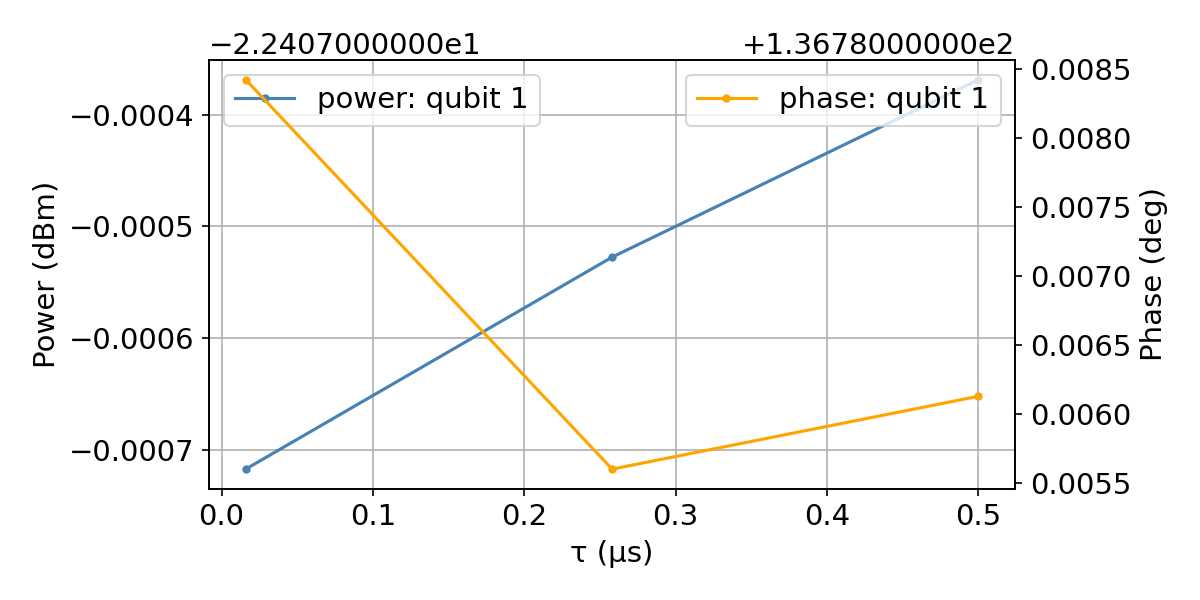

In [21]:
n_cpmg = 2
dr_pulse_amp = dr_pi_amp # pi/2 pulse is configured by command table with amplitude factor of 0.5
dr_df = np.ones(n_q) * 50e6
start = np.ones(n_q) * 16e-9
stop = np.ones(n_q) * 0.5e-6
step = 8e-9 * 40
num_points = int(np.ceil(max(stop - start)/step + 1))
print(f'{num_points} points, step {max(stop-start)/(num_points-1)*1e9} ns')
num_avgs = 2000
delay_after_trigger = 2 * n_cpmg * max(stop) + (n_cpmg+2) * max(dr_pulse_duration) + 0e-6
cycle_time = delay_after_trigger + ro_pulse_duration + 0.2e-6
exp = 'cpmg'

seqc_qa = seqc_qubit_exp_qa(num_points, num_avgs, delay_after_trigger)
device.qachannels[0].generator.load_sequencer_program(seqc_qa)
device.qachannels[0].generator.enable_sequencer(single=True) 

with device.set_transaction():
    device.qachannels[0].readout.result.length(num_points)
    device.qachannels[0].readout.result.averages(num_avgs)
    device.qachannels[0].readout.result.enable(1) # enable result logger
for i in range(n_q):
    device.sgchannels[i].oscs[0].freq(dr_df[i])
    device.sgchannels[i].sines[0].i.enable(0)
    device.sgchannels[i].sines[0].q.enable(0)
    device.sgchannels[i].awg.modulation.enable(1)
    upload_compile_seqc_sg(start[i], stop[i], num_points, num_avgs, avg_mode, dr_pulse_duration[i], 
                                               delay_after_trigger, n_cpmg, exp, True, device, i)
    generate_upload_drive_drag_pulses(dr_pulse_duration[i], dr_pulse_sigma[i], dr_pulse_beta[i], 
                                                    dr_pulse_amp[i], True, device, i)
    upload_ct_sg(exp = exp, upload = True, device = device, channel_index = i)
    device.sgchannels[i].awg.enable(1)
    
device.system.internaltrigger.holdoff(np.max(cycle_time))
device.system.internaltrigger.repetitions(int(num_points*num_avgs))   
device.system.internaltrigger.enable(1)
    
print(f'\n wait at least {cycle_time*num_points*num_avgs} seconds')
progress = 0
while(progress<1):
    progress = device.system.internaltrigger.progress()
    sys.stdout.write(f'\r progress: {int(progress*100)}%')
    sys.stdout.flush()
    
readout_results = device.qachannels[0].readout.read(timeout = num_points/50)
x = np.zeros([n_q, num_points])
for i in range(n_q):
    x = np.linspace(start[i], stop[i], num_points)
plot_qubit_readout_amp_phase(int(integration_length*fs),x, readout_results[0:n_q], exp = exp)

## Discriminate state 

### Discriminate state (2-state only)

  #### Measure integration weights

<IPython.core.display.Javascript object>


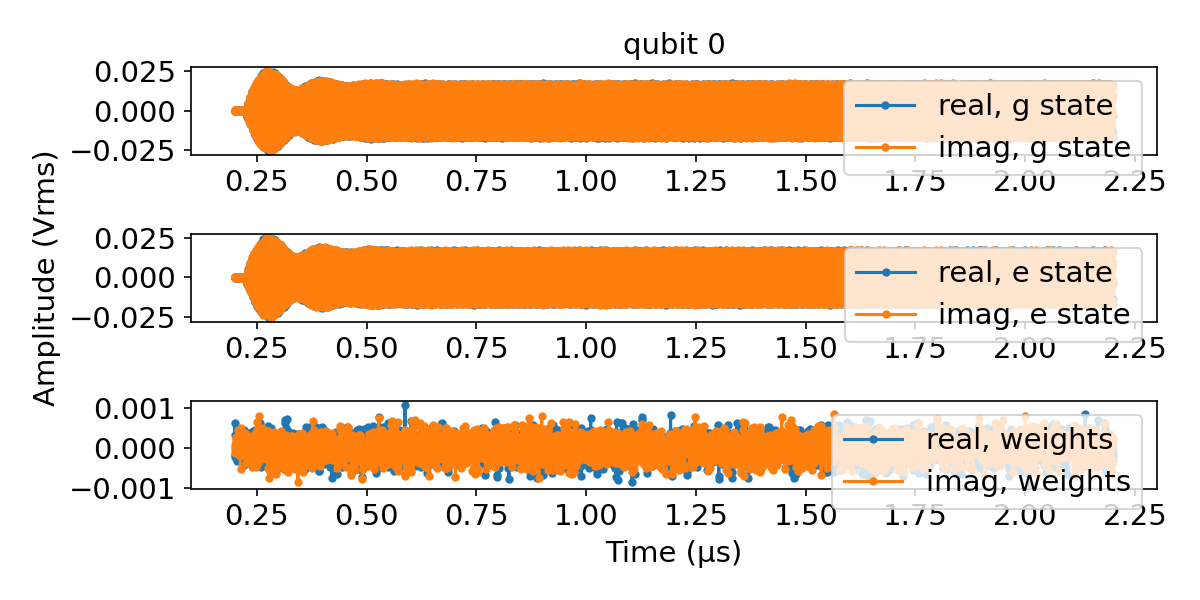

<IPython.core.display.Javascript object>


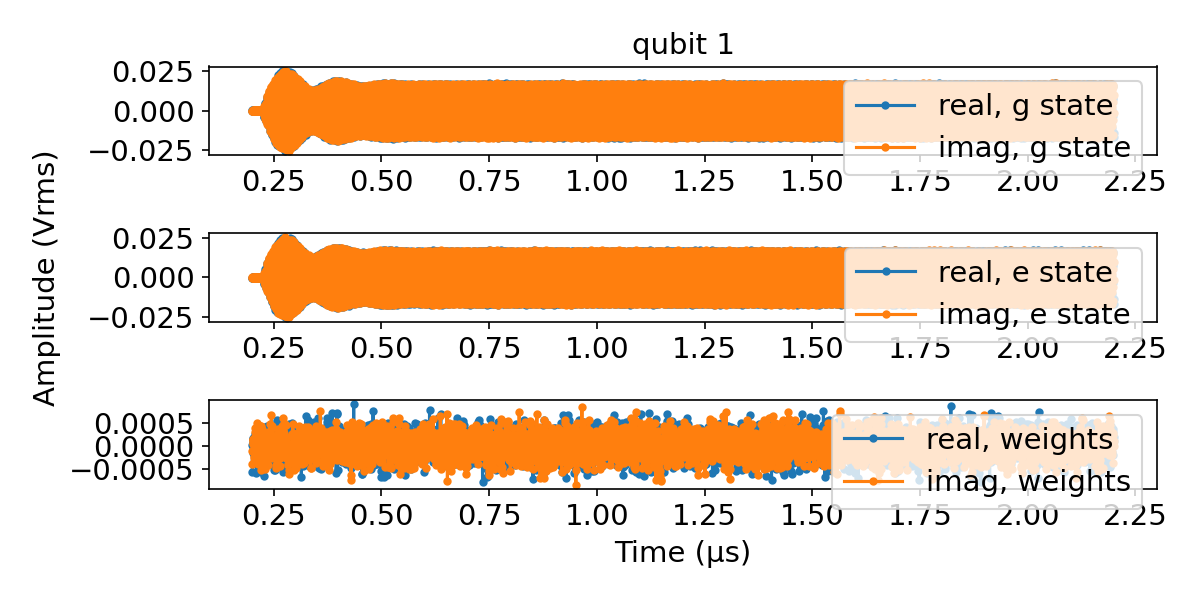

In [59]:
dr_pulse_amp = dr_pi_amp 
dr_df = np.ones(n_q) * 50e6 

num_points = 2 # 2-states
num_avgs = 50
delay_after_trigger = max(stop) + max(dr_pulse_duration) + 1e-6
cycle_time = delay_after_trigger + ro_pulse_duration + 4e-6
exp = 'weights 2-state'

scope_channel = 0
trigger_delay = 200e-9
device.scopes[scope_channel].configure(
    input_select={scope_channel: f"channel0_signal_input"},
    num_samples=int(ro_pulse_duration * fs/16)*16,
    trigger_input=f"chan0seqmon0",
    num_segments=num_points,
    num_averages=num_avgs,
    trigger_delay=trigger_delay,
)

seqc_qa = seqc_qubit_exp_qa(num_points, num_avgs, delay_after_trigger)
device.qachannels[0].generator.load_sequencer_program(seqc_qa)

results = np.zeros((int(ro_pulse_duration * fs/16)*16, int(n_q)), dtype=np.complex128)
weights = Waveforms()
do_plot = 1
with device.set_transaction():
    device.qachannels[0].readout.result.length(num_points)
    device.qachannels[0].readout.result.averages(num_avgs)
    device.qachannels[0].readout.result.mode(1) # 0 cyclic, 1 sequential
    device.qachannels[0].readout.result.enable(1) # enable result logger

for i in range(n_q):
    device.scopes[scope_channel].enable(0)
    device.sgchannels[i].oscs[0].freq(dr_df[i])
    device.sgchannels[i].sines[0].i.enable(0)
    device.sgchannels[i].sines[0].q.enable(0)
    device.sgchannels[i].awg.modulation.enable(1)
    device.qachannels[0].generator.enable_sequencer(single=True) 
    upload_compile_seqc_sg(start[i], stop[i], num_points, num_avgs, avg_mode, dr_pulse_duration[i], 
                                               delay_after_trigger, n_cpmg, exp, True, device, i)
    generate_upload_drive_drag_pulses(dr_pulse_duration[i], dr_pulse_sigma[i], dr_pulse_beta[i], 
                                                    dr_pulse_amp[i], True, device, i)
    upload_ct_sg(exp = exp, upload = True, device = device, channel_index = i)
    device.sgchannels[i].awg.enable(1)
    
    device.scopes[scope_channel].run(single=True)
    device.system.internaltrigger.holdoff(np.max(cycle_time))
    device.system.internaltrigger.repetitions(int(num_points*num_avgs))   
    device.system.internaltrigger.enable(1)

    scope_data, *_ = device.scopes[0].read()
    # Calculates the weights from scope measurements
    # for the excited and ground states
    split_data = np.split(scope_data[scope_channel], 2)
    ground_state_data = split_data[0]
    excited_state_data = split_data[1]
    x = np.linspace(trigger_delay, trigger_delay + len(scope_data[scope_channel])/2/fs, int(len(scope_data[scope_channel])/2))
    results[:,i]=np.conj(excited_state_data - ground_state_data)   
    weights.assign_waveform(i, np.conj(excited_state_data - ground_state_data))
    
    if do_plot is 1:
        fig, (ax0, ax1, ax2) = plt.subplots(3, 1)    
        ax0.plot(x/1e-6, ground_state_data.real, '.-', label = f'real, g state')
        ax0.plot(x/1e-6, ground_state_data.imag, '.-', label = f'imag, g state')    
        ax1.plot(x/1e-6, excited_state_data.real, '.-', label = f'real, e state')
        ax1.plot(x/1e-6, excited_state_data.imag, '.-', label = f'imag, e state')
        ax2.plot(x/1e-6, np.real(np.conj(excited_state_data - ground_state_data)), '.-', label = f'real, weights')
        ax2.plot(x/1e-6, np.imag(np.conj(excited_state_data - ground_state_data)), '.-', label = f'imag, weights')
        ax0.legend(loc='upper right')
        ax1.legend(loc='upper right')
        ax2.legend(loc='upper right')
        ax0.set_title(f'qubit {i}')
        ax2.set_xlabel('Time (μs)')
        ax1.set_ylabel('Amplitude (Vrms)')
        fig.align_ylabels()
        plt.tight_layout()
        plt.show()
        
# device.qachannels[0].readout.integration.clearweight()    
# device.qachannels[0].readout.write_integration_weights(weights)

#### Measure thresholds

<IPython.core.display.Javascript object>


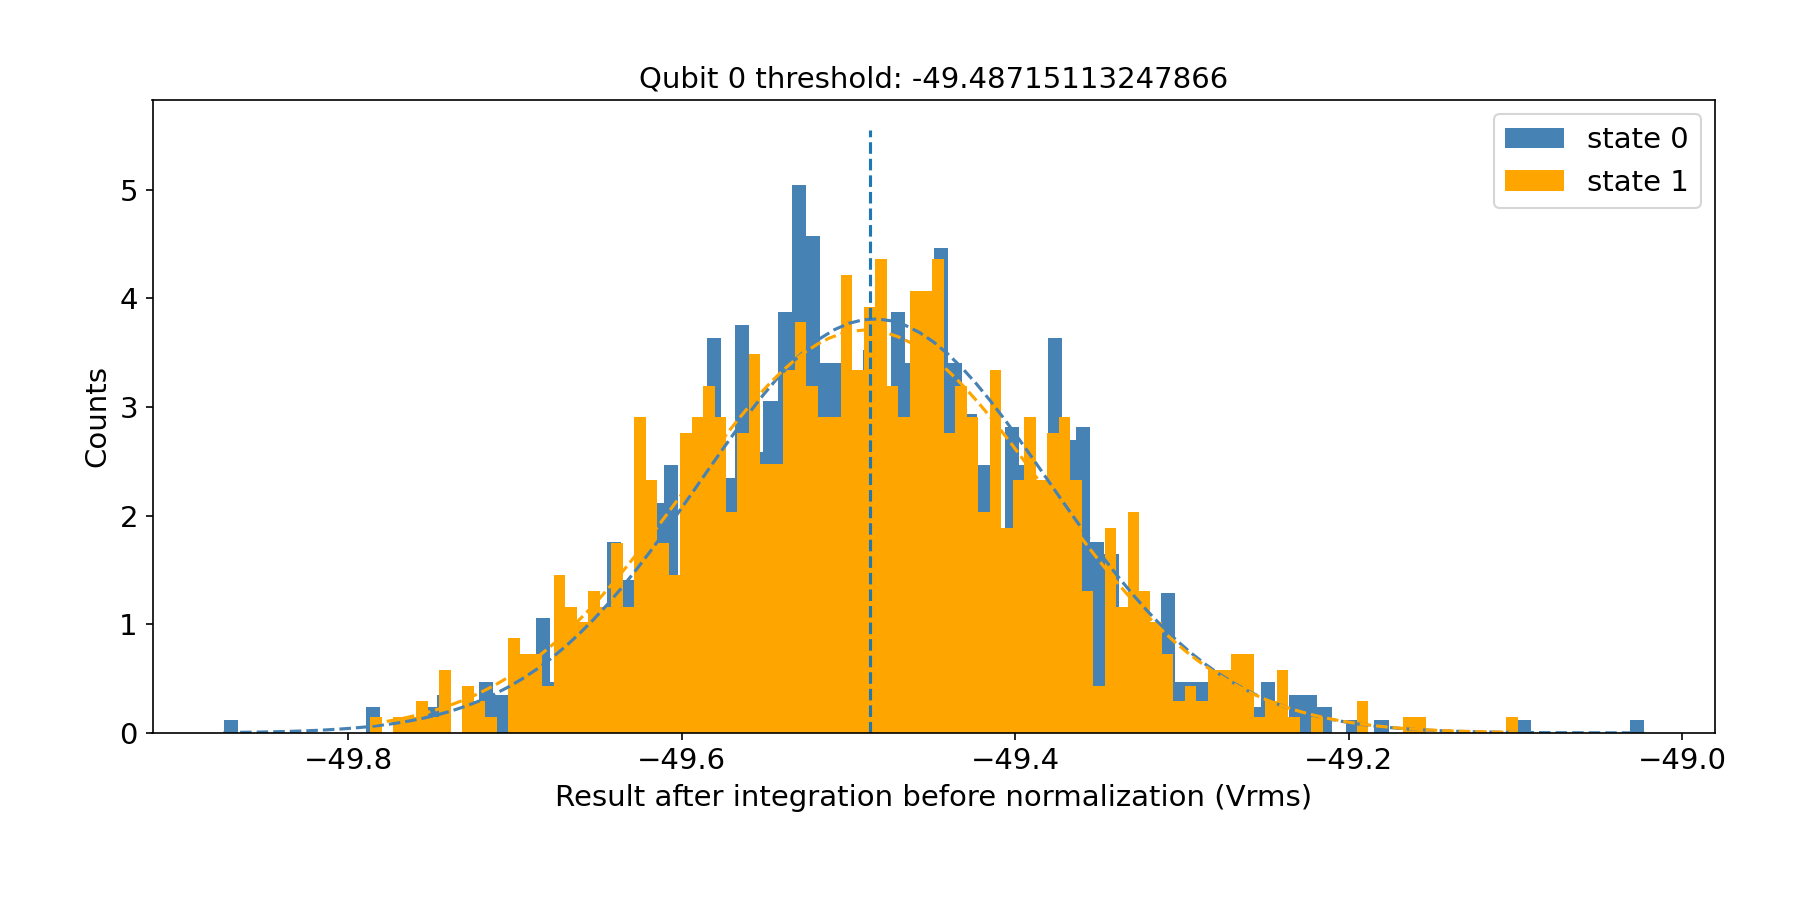

<IPython.core.display.Javascript object>


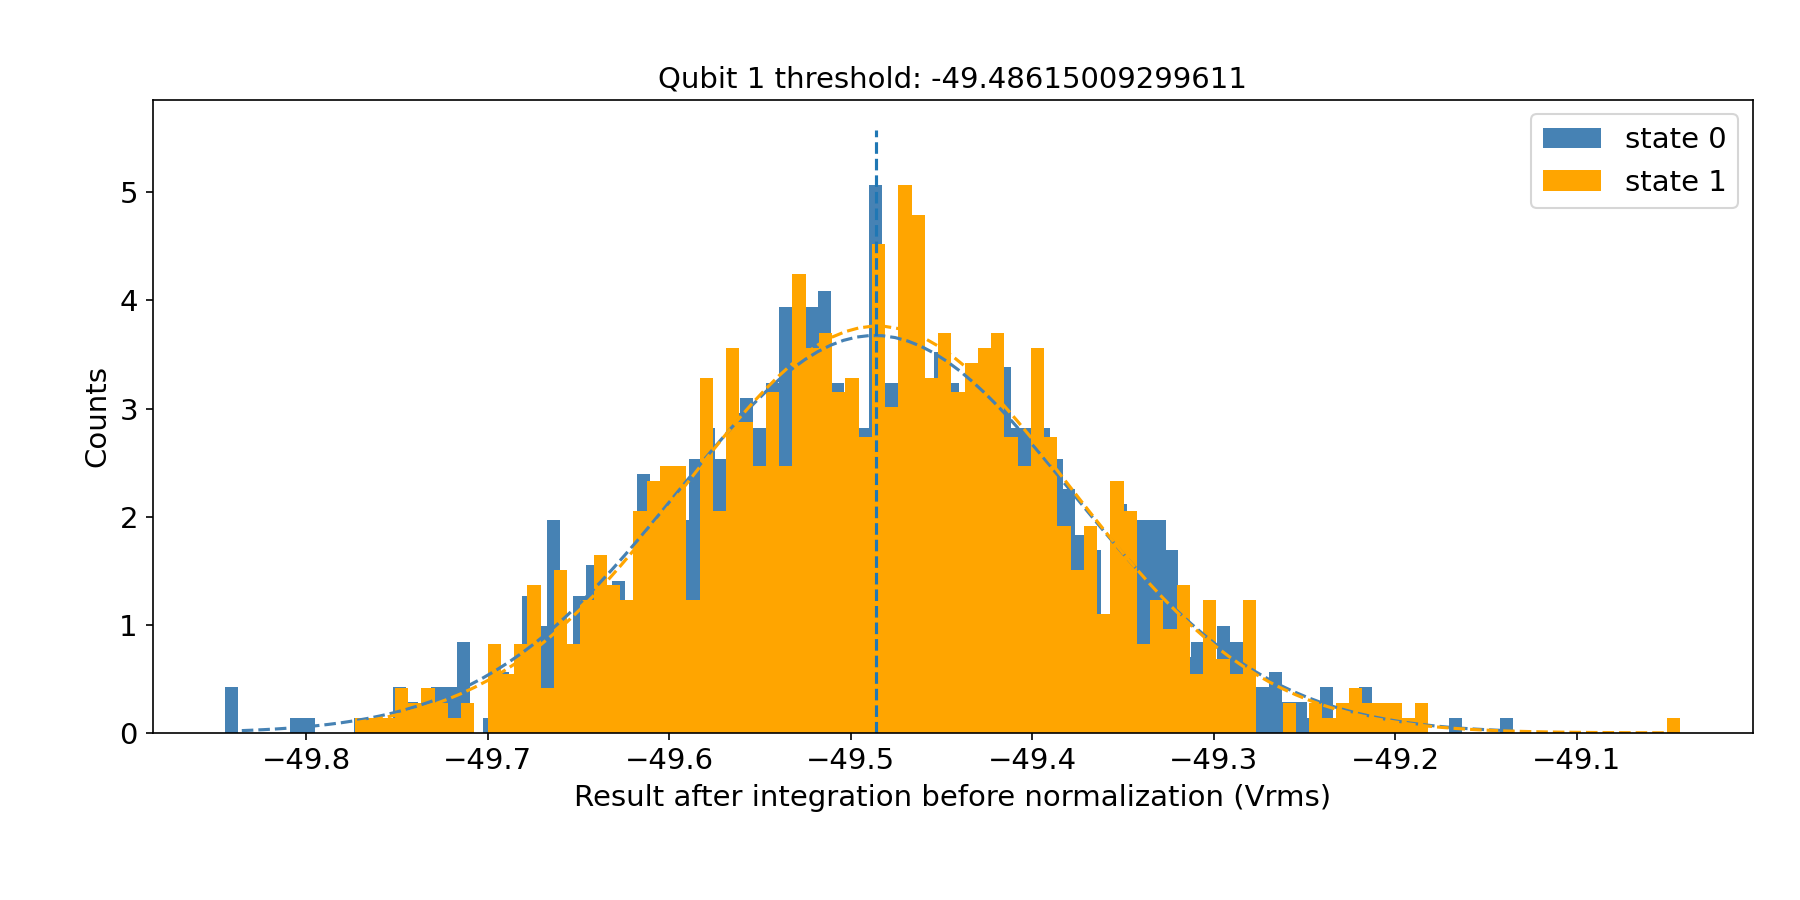

In [69]:
dr_pulse_amp = dr_pi_amp 

num_points = 2000 # 2-states
num_avgs = 1
delay_after_trigger = max(stop) + max(dr_pulse_duration) + 1e-6
cycle_time = delay_after_trigger + ro_pulse_duration + 3e-6
exp = 'thresholds 2-state'

seqc_qa = seqc_qubit_exp_qa(num_points, num_avgs, delay_after_trigger)
device.qachannels[0].generator.load_sequencer_program(seqc_qa)
 

results_results = np.zeros((num_points))
weights = Waveforms()
do_plot = 1
with device.set_transaction():
    device.qachannels[0].readout.result.length(num_points)
    device.qachannels[0].readout.result.averages(num_avgs)
for i in range(n_q):
    upload_compile_seqc_sg(start[i], stop[i], num_points, num_avgs, avg_mode, dr_pulse_duration[i], 
                                               delay_after_trigger, n_cpmg, exp, True, device, i)
    generate_upload_drive_drag_pulses(dr_pulse_duration[i], dr_pulse_sigma[i], dr_pulse_beta[i], 
                                                    dr_pulse_amp[i], True, device, i)
    upload_ct_sg(exp = exp, upload = True, device = device, channel_index = i)
    device.sgchannels[i].awg.enable(1)
    device.qachannels[0].readout.result.enable(1) # enable result logger
    device.qachannels[0].generator.enable_sequencer(single=True)
    device.system.internaltrigger.holdoff(np.max(cycle_time))
    device.system.internaltrigger.repetitions(int(num_points*num_avgs))   
    device.system.internaltrigger.enable(1)

    readout_results = device.qachannels[0].readout.read(timeout = num_points/50)
    threshold, mu_g, mu_g = plot_2_state_threshold_histogram(readout_results, num_bins = 100, ind_q = i)
    device.qachannels[0].readout.discriminators[i].threshold(threshold)

#### Discriminate states with random 0 or 1 state, and calculate assignment fidelity matrix

In [ ]:
dr_pulse_amp = dr_pi_amp 
num_points = 2000 # 2-states
num_avgs = 1
delay_after_trigger = max(stop) + max(dr_pulse_duration) + 1e-6
cycle_time = delay_after_trigger + ro_pulse_duration + 3e-6
exp = 'assignment fidelity 2-state'

prepared_state_vactor = np.zeros(num_points)
for i in range(num_points):
    if i%2 is not 0:
        prepared_state_vactor[i] = 1       
        
seqc_qa = seqc_qubit_exp_qa(num_points, num_avgs, delay_after_trigger)
device.qachannels[0].generator.load_sequencer_program(seqc_qa)

results_results = np.zeros((num_points))
weights = Waveforms()
do_plot = 1
with device.set_transaction():
    device.qachannels[0].readout.result.length(num_points)
    device.qachannels[0].readout.result.averages(num_avgs)
    device.qachannels[0].readout.result.source(3) # discrimination
for i in range(n_q):
    upload_compile_seqc_sg(start[i], stop[i], num_points, num_avgs, avg_mode, dr_pulse_duration[i], 
                                               delay_after_trigger, n_cpmg, exp, True, device, i)
    generate_upload_drive_drag_pulses(dr_pulse_duration[i], dr_pulse_sigma[i], dr_pulse_beta[i], 
                                                    dr_pulse_amp[i], True, device, i)
    upload_ct_sg(exp = exp, upload = True, device = device, channel_index = i)
    device.sgchannels[i].awg.enable(1)
    device.qachannels[0].readout.result.enable(1) # enable result logger
    device.qachannels[0].generator.enable_sequencer(single=True)
    device.system.internaltrigger.holdoff(np.max(cycle_time))
    device.system.internaltrigger.repetitions(int(num_points*num_avgs))   
    device.system.internaltrigger.enable(1)

    readout_results = device.qachannels[0].readout.read(timeout = num_points/50)
    right = np.sum(readout_results == expected_results)



In [98]:
num_points = 100
ayy = np.zeros(num_point) 
expected_results = np.zeros(num_points)
for i in range(num_points):
    if i%2 is not 0:
        expected_results[i] = 1 
        
right = np.sum(expected_results == 1)
right/num_points
    

0.5

In [53]:
def calc_expected_qudits_results(qudits_num_states, result_len):
    """Calculates the expected discrimination results.

    The states of each qudit are counted up subsequently while keeping the other
    qudits in the ground state.
    """
    expected_qudits_results = {}
    total_num_states = sum(qudits_num_states.values())
    first_state_idx = 0
    for qudit_idx, num_states in qudits_num_states.items():
        expected_result_vector = np.zeros(result_len, dtype=int)
        start_idx = first_state_idx
        qudit_states = np.arange(num_states, dtype=int)
        while start_idx < result_len:
            end_idx = min(start_idx + num_states, result_len)
            expected_result_vector[start_idx:end_idx] = qudit_states
            start_idx += total_num_states
        expected_qudits_results[qudit_idx] = expected_result_vector
        # the states of the next qudit will start counting up only after the states of this qudit
        first_state_idx += num_states

    return expected_qudits_results


expected_qudits_results = calc_expected_qudits_results(
    QUDITS_NUM_STATES, len(qudits_results[0])
)
def calc_fidelity_matrix(measured_results, expected_results, num_states):
    """Calculates the fidelity matrix.

    Row indices correspond to the expected state, Column indices to the actual state
    """

    fidelity_matrix = np.zeros([num_states, num_states])
    for expected_state, measured_state in zip(expected_results, measured_results):
        fidelity_matrix[expected_state, measured_state] += 1

    # normalize row-by-row by the expected number of occurrences for each state
    for (
        expected_state,
        matrix_row,
    ) in enumerate(fidelity_matrix):
        state_sum = np.sum(expected_results == expected_state)
        fidelity_matrix[expected_state] = fidelity_matrix[expected_state] / state_sum

    return fidelity_matrix


qudits_fidelity_matrix = {}

for qudit_idx, result_vector in qudits_results.items():

    qudits_fidelity_matrix[qudit_idx] = calc_fidelity_matrix(
        result_vector,
        expected_qudits_results[qudit_idx],
        QUDITS_NUM_STATES[qudit_idx],
    )
def plot_fidelity_matrix(matrix, title=None):
    fig, ax = plt.subplots()
    min_val, max_val = 0, 5

    ax.matshow(matrix, cmap="Blues")

    for iy, ix in np.ndindex(matrix.shape):
        value = matrix[iy, ix]
        color = "black" if value < 0.5 else "white"
        ax.text(ix, iy, f"{value:0.3f}", va="center", ha="center", color=color)

    plt.xlabel("Measured state")
    plt.ylabel("Expected state")

    if title:
        plt.title(title)

    plt.show()


for qudit_idx, fidelity_matrix in qudits_fidelity_matrix.items():
    plot_fidelity_matrix(fidelity_matrix, title=f"Qudit {qudit_idx}")

array([[-49.57428813+46.36287107j, -49.54008088+46.33840625j,
        -49.58396115+46.27419496j, ..., -49.63754972+46.39878688j,
        -49.68035585+46.52131337j, -49.37797894+46.32142046j],
       [-49.57428813+46.36287107j, -49.54008088+46.33840625j,
        -49.58396115+46.27419496j, ..., -49.63754972+46.39878688j,
        -49.68035585+46.52131337j, -49.37797894+46.32142046j],
       [  0.         +0.j        ,   0.         +0.j        ,
          0.         +0.j        , ...,   0.         +0.j        ,
          0.         +0.j        ,   0.         +0.j        ],
       ...,
       [  0.         +0.j        ,   0.         +0.j        ,
          0.         +0.j        , ...,   0.         +0.j        ,
          0.         +0.j        ,   0.         +0.j        ],
       [  0.         +0.j        ,   0.         +0.j        ,
          0.         +0.j        , ...,   0.         +0.j        ,
          0.         +0.j        ,   0.         +0.j        ],
       [  0.         +0.j   

<IPython.core.display.Javascript object>


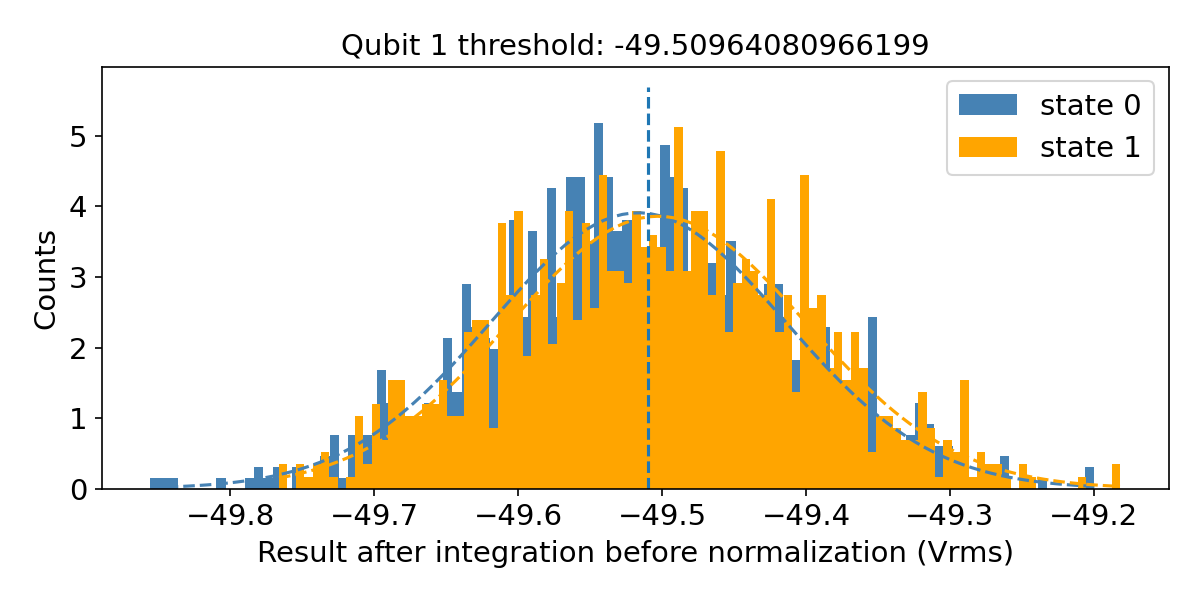

In [52]:
import scipy as scy
from numpy import loadtxt
from scipy.optimize import leastsq
from scipy.stats import norm

fitfunc  = lambda p, x: p[0]*exp(-0.5*((x-p[1])/p[2])**2)+p[3]
errfunc  = lambda p, x, y: (y - fitfunc(p, x))

num_bins = 100
ind_q = 1
g_real = np.real(readout_results[0][0:1000])
g_imag = np.imag(readout_results[0][0:1000])
e_real = np.real(readout_results[0][1000::])
e_imag = np.imag(readout_results[0][1000::])
(g_mu, g_sigma) = norm.fit(g_real)
(e_mu, e_sigma) = norm.fit(e_real)

fitfunc  = lambda p, x: p[0]*exp(-0.5*((x-p[1])/p[2])**2)+p[3]
errfunc  = lambda p, x, y: (y - fitfunc(p, x))

fig, ax = plt.subplots()

g_n, g_bins, g_patches = ax.hist(g_real, num_bins, density=1, label = 'state 0', color = 'steelblue')
e_n, e_bins, e_patches = ax.hist(e_real, num_bins, density=1, label = 'state 1', color = 'orange')

g_init  = [max(g_n), g_mu, g_sigma, min(g_n)]
e_init  = [max(e_n), e_mu, e_sigma, min(e_n)]

mu_g, sigma_g = scy.stats.norm.fit(g_real)
mu_e, sigma_e = scy.stats.norm.fit(e_real)
threshold = np.mean([mu_g, mu_e])
best_fit_line_g = scy.stats.norm.pdf(g_bins, mu_g, sigma_g)
best_fit_line_e = scy.stats.norm.pdf(e_bins, mu_e, sigma_e)
plt.plot(g_bins, best_fit_line_g, '--', color = 'steelblue')
plt.plot(e_bins, best_fit_line_e, '--', color = 'orange')
plt.plot(np.ones(10)*threshold, np.linspace(0, 1.1*max(g_n), 10), '--')
plt.xlabel('Result after integration before normalization (Vrms)')
plt.ylabel('Counts')
plt.title(f'Qubit {ind_q} threshold: {threshold}')
plt.legend()
plt.show()
plt.tight_layout()

In [ ]:
mu_g

In [ ]:
mu_e

In [ ]:
e_mu

In [ ]:
from pylab import *
from numpy import loadtxt
from scipy.optimize import leastsq

fitfunc  = lambda p, x: p[0]*exp(-0.5*((x-p[1])/p[2])**2)+p[3]
errfunc  = lambda p, x, y: (y - fitfunc(p, x))

In [ ]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(19680801)

# example data
mu = 100  # mean of distribution
sigma = 15  # standard deviation of distribution
x = mu + sigma * np.random.randn(437)

num_bins = 50

fig, ax = plt.subplots()

# the histogram of the data
n, bins, patches = ax.hist(x, num_bins, density=1)

# add a 'best fit' line
y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
# ax.plot(bins, y, '--')
ax.set_xlabel('Smarts')
ax.set_ylabel('Probability density')
ax.set_title(r'Histogram of IQ: $\mu=100$, $\sigma=15$')

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()

In [ ]:
# plt.figure()
# plt.plot(ground_state_data.real,'.-')
# plt.plot(ground_state_data.imag, '.-')

# len(ground_state_data[0])
a= scope_data[0][int(len(scope_data[0])/2):]
len(a)

In [ ]:
weights[0]

In [ ]:
1+0j

In [ ]:
for i in range(80):
    device.scopes[0].run(single=True)
    device.qachannels[0].generator.enable_sequencer(single=True)
    time.sleep(1)

In [ ]:
# pip install --upgrade zhinst-toolkit